In [225]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from copy import deepcopy
from keras import models,layers,regularizers
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [226]:
train = pd.read_csv('train.csv')

In [227]:
train.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [228]:
train.shape

(900, 11)

In [229]:
train.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased'],
      dtype='object')

In [230]:
train.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
Deceased                               int64
dtype: object

In [231]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [232]:
train.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [233]:
for col in ['Severity','Birthday_year','Medical_Tent','City']:
    print(col + ':', train[col].unique())

Severity: [3 1 2]
Birthday_year: [  nan 1966. 1982. 1997. 1994. 1984. 1989. 2000. 2009. 1999. 1991. 2019.
 1964. 2017. 1987. 2011. 1998. 2002. 1992. 1981. 1990. 1978. 2001. 1958.
 1996. 2004. 1962. 1970. 1985. 1965. 2018. 1995. 1956. 2003. 1986. 1971.
 1983. 2005. 1975. 1950. 2016. 2013. 1980. 1979. 2014. 1988. 1993. 1968.
 2006. 1973. 2007. 2012. 1946. 1974. 1972. 2008. 1976. 1961. 1957. 1960.
 1959. 2015. 2010. 1969. 1949. 1955. 1977. 1963. 1954. 1967. 1940.]
Medical_Tent: [nan 'F' 'B' 'A' 'E' 'C' 'D' 'G' 'T']
City: ['Santa Fe' 'Albuquerque' 'Taos' nan]


In [234]:
train.duplicated().any()

False

In [235]:
train.groupby(['Deceased']).count()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
Deceased,,,,,,,,,,
0,347,347,347,347,295,347,347,347,131,345
1,553,553,553,553,428,553,553,553,67,553


In [236]:
data = train.drop(['Patient_ID','Deceased'],1)
target = train['Deceased']

Only three columns: Severity, Medical_Tent, and City, are categorical variables, and only Name, Medical_Tent, and City are non-numerical.

The values for all variables seem to be within the expected range.

There are null values in the columns: Birthday_year, Medical_Tent, and City.

There are no duplicated lines.

The target classes are not balanced.

## Preprocessing

### Add New Variables

`Infected_per_Family` Sum of Parents or sibilings infected and Wife/Husband or children infected<br>
`Maritial_state` 1 if it is married 0 otherwise <br>
`Gender` 1 if it is female 0 otherwise <br>
`Is_young: `0 if the age is lower than 60, 1 otherwise<br>

In [237]:
data['Infected_per_Family'] = data['Parents or siblings infected'] + data['Wife/Husband or children infected']
data['Marital_Status'] = 0
data['Gender'] = 0
data['Title'] = 0
# 2020-60 = 1960
data['Is_young'] = 0
for i in data.index:
    if data['Birthday_year'][i]<=1960:
        data['Is_young'][i] = 0
    elif data['Birthday_year'][i]>1960:
        data['Is_young'][i] = 1
    else:
        data['Is_young'][i] = None

In [238]:
data['Title_Miss'] = data['Name']
data['Title_Ms'] = data['Name']
data['Title_Mrs'] = data['Name']
data['Title_Mr'] = data['Name']
data['Title_Master'] = data['Name']

for i in data.index:
    if data['Name'][i].startswith('Miss'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 1
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Ms.'):
        data['Marital_Status'][i] = None
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 1
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mrs.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 1
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 1
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Mr.'):
        data['Marital_Status'][i] = 1
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 1
        data['Title_Master'][i] = 0
        
    elif data['Name'][i].startswith('Master'):
        data['Marital_Status'][i] = 0
        data['Gender'][i] = 0
        data['Title_Miss'][i] = 0
        data['Title_Ms'][i] = 0
        data['Title_Mrs'][i] = 0
        data['Title_Mr'][i] = 0
        data['Title_Master'][i] = 1

In [239]:
data[data['Marital_Status'].isnull()].shape

(209, 19)

### Encoding Categorical Values

Because the label encoder does not work with null values in the data frame, but we need the variables to be encoded to use a KNNImputer, first we are replacing the all null value in the City column with a dummy, absurd variable, run the encoder, and then turn them back to nulls.

In [240]:
data['City'].mode()[0]

'Santa Fe'

In [241]:
data['City'] = data['City'].fillna(data['City'].mode()[0])

In [242]:
data['City_SantaFe'] = data['City']
data['City_Albuquerque'] = data['City']
data['City_Taos'] = data['City']

for i in data['City'].index:
    if data['City'][i] == 'Santa Fe':
        data['City_SantaFe'][i] = 1
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Albuquerque':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 1
        data['City_Taos'][i] = 0
    elif data['City'][i] == 'Taos':
        data['City_SantaFe'][i] = 0
        data['City_Albuquerque'][i] = 0
        data['City_Taos'][i] = 1

In [243]:
data.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,...,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,0,...,0,NaN,1,0,0,0,0,1,0,0
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,1,...,0,1.0,0,1,0,0,0,0,1,0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0,...,0,1.0,0,1,0,0,0,1,0,0


### Null Values

There were null values in the columns Birthday_year, City and Medical_Tent.

- **Birthday_year:** 117 (13% of the data)
- **Medical_Tent:** 702 (78% of the data)
- **City:** 2

And the new column Marital_Status also has null values:

- **Marital_Status:** 209 (23% of the data)

In [244]:
data[data.isnull().any(axis=1)]

,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Infected_per_Family,...,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,0,...,0,NaN,1,0,0,0,0,1,0,0
1,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,1,...,0,1.0,0,1,0,0,0,0,1,0
2,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0,...,0,1.0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253,3,Ms. Linda Wilcox,1998.0,1,1,344,NaN,Santa Fe,2,...,0,1.0,0,1,0,0,0,1,0,0
896,6483,3,Mr. Haiden Vance,2006.0,0,0,258,NaN,Santa Fe,0,...,0,1.0,0,0,0,1,0,1,0,0
897,981,3,Miss Anaiya Love,1990.0,0,0,214,NaN,Taos,0,...,0,1.0,1,0,0,0,0,0,0,1
898,16418,2,Mr. Robert Williams,1994.0,1,1,812,NaN,Santa Fe,2,...,0,1.0,0,0,0,1,0,1,0,0


In [245]:
data[data.isnull().any(axis=1)].shape

(796, 22)

In [246]:
null_ind = data[data.isnull().any(axis=1)].index

In [247]:
len(null_ind)

796

There are 78% of the data missing on the Medical_Tent column, this is too much therefore this column will be dropped.

Since there are only two null values in the column City, they can simply be replaced using the mode.

In the birthday year column values can be replaced with either the median (since it's less sensible to outliers), or KNNImputer, and for the Is_young columns the mode or KNNImputer can be used, if Birthday_year is not available to compute it.

In [248]:
def null_values(data, method='knn', k=1): 
    # drop the Medical_Tent column 
    data = data.drop(['Medical_Tent'],1)
    
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(data)
        data = pd.DataFrame(data=imputer.transform(data),columns=data.columns,index=data.index)
        
    if method == 'stat':
        cols = []
        for col in ['Birthday_year','Is_young','Marital_Status']:
            if col in data.columns:
                cols.append(col)
                
        if 'Birthday_year' in cols:
            data['Birthday_year'] = data['Birthday_year'].fillna(round(data['Birthday_year'].median()))
            if 'Is_young' in cols:
                for i in data['Is_young'].isna().index:
                    if data['Birthday_year'][i]<=1960:
                        data['Is_young'][i] = 0
                    elif data['Birthday_year'][i]>1960:
                        data['Is_young'][i] = 1
        elif 'Is_young' in cols:
            data['Is_young'] = data['Is_young'].fillna(float(data['Is_young'].mode()))
            
        if 'Marital_Status' in cols:
            data['Marital_Status'] = data['Marital_Status'].fillna(float(data['Marital_Status'].mode()))
                
    return data

In [249]:
null_values(data.drop(['Name','City'],1),method='stat').iloc[null_ind,:]

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Infected_per_Family,Marital_Status,Gender,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,4696,3,1992.0,0,0,225,0,0.0,1,0,1.0,1,0,0,0,0,1,0,0
1,21436,1,1966.0,0,1,1663,1,1.0,1,0,1.0,0,1,0,0,0,0,1,0
2,7273,3,1982.0,0,0,221,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
3,8226,3,1997.0,0,0,220,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
4,19689,3,1994.0,0,0,222,0,1.0,1,0,1.0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,6253,3,1998.0,1,1,344,2,1.0,1,0,1.0,0,1,0,0,0,1,0,0
896,6483,3,2006.0,0,0,258,0,1.0,0,0,1.0,0,0,0,1,0,1,0,0
897,981,3,1990.0,0,0,214,0,0.0,1,0,1.0,1,0,0,0,0,0,0,1
898,16418,2,1994.0,1,1,812,2,1.0,0,0,1.0,0,0,0,1,0,1,0,0


### Outliers

Since all categorical variables have values within the expected range, we're going to check only the continuous variables for outliers.

In [250]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

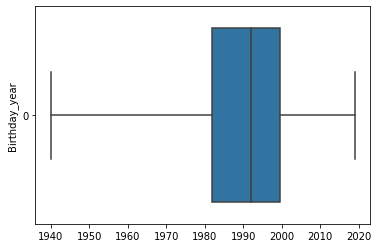

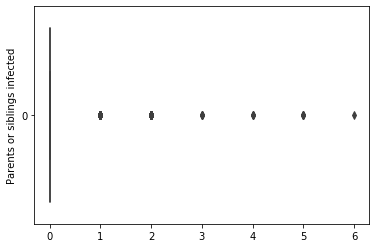

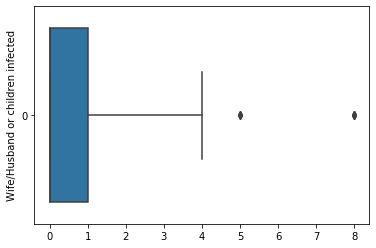

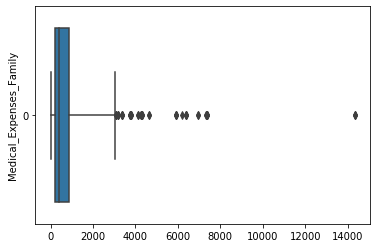

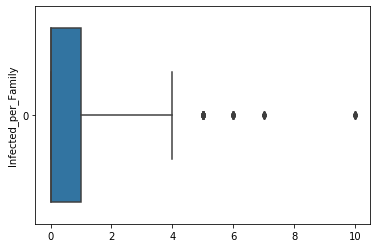

In [251]:
col = ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']

for c in col:
    sns.boxplot(data=data[c],orient='h',whis=3.5)
    plt.ylabel(c)
    plt.show()

In [252]:
def outliers(data, target, std=3, remove=False, pr=False):
    cols = []
    for col in ['Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
        if col in data.columns:
            cols.append(col)
    
    ind = []
    ind_to_remove = []
    
    if len(cols)>0:
        out = data[cols]
        out = pd.DataFrame(data=StandardScaler().fit_transform(out),index=out.index,columns=out.columns)

        for col in out.columns:
            ind_col = list(out[(out[col]<-std)|(out[col]>std)].index)
            ind += ind_col

        for i in ind:
            if i not in ind_to_remove:
                ind_to_remove.append(i)
            
    if pr == True:
        print(len(ind_to_remove))
    
    if remove == True:
        for i in ind_to_remove:
            data = data.drop(i,0)
            target = target.drop(i,0)
        
        return data, target

In [253]:
outliers(data, target, pr=True)

66


This is around 7% of the data, and so an acceptable number of outliers to remove.

These outliers can be ignored or removed.

### Oversampling

Since the target variable is unbalanced, a hypothesis is to balance the dataset through oversampling. Undersampling was not considered because there's not much data to begin with.

In [254]:
def oversample(data, target):
    X = pd.concat([data, target], axis=1)      

    false = X[X.Deceased==0]
    true = X[X.Deceased==1]    

    false_upsampled = resample(false,
                               replace=True, # sample with replacement
                               n_samples=len(medium), # match number in majority class
                               random_state=27) # reproducible results        

    upsampled = pd.concat([false_upsampled, true])

    data = upsampled.drop(['Deceased'],1)
    target = upsampled['Deceased']   

    return data, target

## Tuning Hyperparameters

In [255]:
def avg_score(model_, method='knn', k=1, remove=False, std=3, oversampling=False, scaler=MinMaxScaler(), grid_search=False, parameters=None, features=False):
    # apply kfold
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    data__ = data.drop(['Name','City','Title'],1)
    
    """cat_col = []
    num_col = []

    for col in data__.columns:
        if col in ['Severity','City','Marital_Status','Gender','Title','Is_young']:
            cat_col.append(col)
        elif col in ['Family_Case_ID','Birthday_year','Parents or siblings infected','Wife/Husband or children infected','Medical_Expenses_Family','Infected_per_Family']:
            num_col.append(col)
    
    anova = pd.Series(data=0,index=num_col)
    chi = pd.Series(data=0,index=cat_col)"""
    
    for train_index, test_index in kf.split(data__,target):
        model = deepcopy(model_)
        
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data__.iloc[train_index], data__.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # deal with the null values
        X_train = null_values(X_train, method=method, k=k)
        X_test = null_values(X_test, method=method,k=k)
            
        # deal with outliers
        if remove == True:
            X_train, y_train = outliers(X_train, y_train, std=std, remove=remove)
        
        # oversample the minority class
        if oversampling == True:
            X_train, y_train = oversample(X_train, y_train)
            
        """if features == True:
            data_cat = X_train[cat_col]
            data_num = X_train[num_col]
            
            anova_ = pd.Series(data=f_classif(data_num,y_train)[0],index=data_num.columns)
            chi_ = pd.Series(data=chi2(data_cat,y_train)[0],index=data_cat.columns)
            
            anova += anova_
            chi += chi_"""
            
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best features
        if features == True:
            rfe = RFECV(estimator = model,n_jobs=-1,scoring='accuracy')
            X_train = rfe.fit_transform(X_train,y_train)
            X_test = rfe.transform(X_test)
            print(rfe.ranking_)
            print(X_train.shape)
        
        # find the best hyperparameters
        if grid_search == True:
            clf = GridSearchCV(model,parameters,n_jobs=-1,scoring='accuracy')
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            print(clf.best_params_)
            
        # fit the model to the data
        model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=250,batch_size=32,verbose=0)
        
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        #print(Y_pred)
        
        # check the mean f1-score for the train
        value_train = model.evaluate(X_train,y_train)[1]
        print(value_train)
        
        # check the mean f1-score for the test
        value_test = model.evaluate(X_test,y_test)[1]
        print(value_test)
        
        # print a classification report and confusion matrix
        #print(classification_report(y_true=y_test,y_pred=y_pred))
        #print(confusion_matrix(y_true=y_test,y_pred=y_pred))
        
        # append the scores, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    """if features == True:
        anova = anova.sort_values(ascending=False)
        chi = chi.sort_values(ascending=False)
        
        print(anova)
        print(chi)"""
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [256]:
def show_results(df, models, method = 'knn', k = 1, remove = False, std = 3, oversampling = False, scaler = MinMaxScaler(), parameters = None,features=False):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        parameter_space = None
        if parameters != None:
            parameter_space = parameters[models.index(model)]
            
        if parameter_space == None:
            grid_search = False
        else:
            grid_search = True
                
        print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(model, method = method, k = k, remove = remove, std = std, oversampling = oversampling, grid_search = grid_search, scaler = scaler, parameters = parameter_space, features = features)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1

    return df

In [130]:
def build_model(shape,nodes=64,activation='relu',optimizer='rmsprop',loss='binary_crossentropy'):
    np.random.seed(1)
    tf.random.set_seed(2)
    model = models.Sequential()
    model.add(layers.Dense(nodes,activation=activation,input_shape=(shape,)))
    model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(nodes,kernel_regularizer=regularizers.l2(0.001),activation=activation,input_shape=(shape,)))
    model.add(layers.Dense(nodes,activation=activation))
    model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(nodes,kernel_regularizer=regularizers.l2(0.001),activation=activation))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
    return model

In [104]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City',
       'Infected_per_Family', 'Marital_Status', 'Gender', 'Title', 'Is_young',
       'Title_Miss', 'Title_Ms', 'Title_Mrs', 'Title_Mr', 'Title_Master',
       'City_SantaFe', 'City_Albuquerque', 'City_Taos'],
      dtype='object')

In [105]:
data.shape

(900, 22)

In [131]:
model_16 = build_model(18,16)
model_32 = build_model(18,32)
model_64 = build_model(18)
model_128 = build_model(18,128)

In [132]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[16,32,64,128])
show_results(df,[model_16,model_32,model_64,model_128])

----------------------------------
720/720 [==============================] - 0s 18us/step
0.8291666507720947
180/180 [==============================] - 0s 44us/step
0.8111110925674438
720/720 [==============================] - 0s 29us/step
0.8333333134651184
180/180 [==============================] - 0s 50us/step
0.7611111402511597
720/720 [==============================] - 0s 24us/step
0.8291666507720947
180/180 [==============================] - 0s 56us/step
0.8111110925674438
720/720 [==============================] - 0s 26us/step
0.8222222328186035
180/180 [==============================] - 0s 72us/step
0.8166666626930237
720/720 [==============================] - 0s 21us/step
0.8208333253860474
180/180 [==============================] - 0s 61us/step
0.800000011920929
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8708333373069763
180/180 [==============================] - 0s 39us/step
0.8055555820465088
720/720 [======================

,Time,Train,Test
16,9.257+/-0.63,0.827+/-0.0,0.8+/-0.02
32,10.898+/-0.19,0.861+/-0.01,0.813+/-0.02
64,12.144+/-0.16,0.861+/-0.01,0.817+/-0.03
128,15.952+/-0.11,0.868+/-0.01,0.804+/-0.03


In [124]:
model_relu = build_model(18)
model_tanh = build_model(18,activation='tanh')

In [125]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['relu','tanh'])
show_results(df,[model_relu,model_tanh])

----------------------------------
720/720 [==============================] - 0s 28us/step
0.8597221970558167
180/180 [==============================] - 0s 33us/step
0.8166666626930237
720/720 [==============================] - 0s 28us/step
0.8666666746139526
180/180 [==============================] - 0s 44us/step
0.7666666507720947
720/720 [==============================] - 0s 33us/step
0.8541666865348816
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 38us/step
0.8402777910232544
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 31us/step
0.8527777791023254
180/180 [==============================] - 0s 67us/step
0.8055555820465088
----------------------------------
720/720 [==============================] - 0s 19us/step
0.8069444298744202
180/180 [==============================] - 0s 33us/step
0.7888888716697693
720/720 [=====================

,Time,Train,Test
relu,9.443+/-0.8,0.855+/-0.01,0.811+/-0.02
tanh,10.445+/-0.33,0.813+/-0.01,0.783+/-0.02


In [126]:
model_rmsprop = build_model(18)
model_adam = build_model(18,optimizer='adam')

In [127]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['rmsprop','adam'])
show_results(df,[model_rmsprop,model_adam])

----------------------------------
720/720 [==============================] - 0s 21us/step
0.8597221970558167
180/180 [==============================] - 0s 39us/step
0.8166666626930237
720/720 [==============================] - 0s 19us/step
0.8666666746139526
180/180 [==============================] - 0s 39us/step
0.7666666507720947
720/720 [==============================] - 0s 25us/step
0.8541666865348816
180/180 [==============================] - 0s 61us/step
0.8277778029441833
720/720 [==============================] - 0s 29us/step
0.8402777910232544
180/180 [==============================] - 0s 44us/step
0.8388888835906982
720/720 [==============================] - 0s 22us/step
0.8527777791023254
180/180 [==============================] - 0s 50us/step
0.8055555820465088
----------------------------------
720/720 [==============================] - 0s 21us/step
0.8680555820465088
180/180 [==============================] - 0s 39us/step
0.8111110925674438
720/720 [=====================

,Time,Train,Test
rmsprop,9.919+/-0.64,0.855+/-0.01,0.811+/-0.02
adam,10.933+/-0.34,0.862+/-0.01,0.818+/-0.02


In [128]:
model_bin = build_model(18)
model_mse = build_model(18,loss='mse')

In [129]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['binary','mse'])
show_results(df,[model_bin,model_mse])

----------------------------------
720/720 [==============================] - 0s 21us/step
0.8597221970558167
180/180 [==============================] - 0s 56us/step
0.8166666626930237
720/720 [==============================] - 0s 22us/step
0.8666666746139526
180/180 [==============================] - 0s 78us/step
0.7666666507720947
720/720 [==============================] - 0s 22us/step
0.8541666865348816
180/180 [==============================] - 0s 50us/step
0.8277778029441833
720/720 [==============================] - 0s 21us/step
0.8402777910232544
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 22us/step
0.8527777791023254
180/180 [==============================] - 0s 61us/step
0.8055555820465088
----------------------------------
720/720 [==============================] - 0s 22us/step
0.875
180/180 [==============================] - 0s 50us/step
0.800000011920929
720/720 [==============================] - 0

,Time,Train,Test
binary,9.799+/-0.85,0.855+/-0.01,0.811+/-0.02
mse,9.694+/-0.4,0.862+/-0.01,0.81+/-0.02


In [134]:
model = build_model(18)
df = pd.DataFrame(columns=['Time','Train','Test'],index=['model'])
show_results(df,[model])

----------------------------------
720/720 [==============================] - 0s 19us/step
0.8666666746139526
180/180 [==============================] - 0s 72us/step
0.8055555820465088
720/720 [==============================] - 0s 25us/step
0.8736110925674438
180/180 [==============================] - 0s 39us/step
0.7666666507720947
720/720 [==============================] - 0s 42us/step
0.8597221970558167
180/180 [==============================] - 0s 44us/step
0.8388888835906982
720/720 [==============================] - 0s 22us/step
0.8513888716697693
180/180 [==============================] - 0s 56us/step
0.8666666746139526
720/720 [==============================] - 0s 26us/step
0.8527777791023254
180/180 [==============================] - 0s 50us/step
0.7944444417953491


,Time,Train,Test
model,11.369+/-0.8,0.861+/-0.01,0.814+/-0.03


## Tests

### Data Cleaning and Scaling

Given that there are so many alternatives on how to clean and scale the data, they're going to be tested against each other.

In [138]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model])

----------------------------------
720/720 [==============================] - 0s 21us/step
0.8680555820465088
180/180 [==============================] - 0s 111us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.875
180/180 [==============================] - 0s 89us/step
0.7666666507720947
720/720 [==============================] - 0s 21us/step
0.862500011920929
180/180 [==============================] - 0s 61us/step
0.8277778029441833
720/720 [==============================] - 0s 31us/step
0.8430555462837219
180/180 [==============================] - 0s 72us/step
0.8611111044883728
720/720 [==============================] - 0s 26us/step
0.8583333492279053
180/180 [==============================] - 0s 56us/step
0.8166666626930237


,Time,Train,Test
model,11.441+/-0.96,0.861+/-0.01,0.818+/-0.03


In [140]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 18us/step
0.8763889074325562
180/180 [==============================] - 0s 61us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.8777777552604675
180/180 [==============================] - 0s 44us/step
0.7833333611488342
720/720 [==============================] - 0s 21us/step
0.8708333373069763
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 39us/step
0.862500011920929
180/180 [==============================] - 0s 67us/step
0.8277778029441833
720/720 [==============================] - 0s 22us/step
0.8763889074325562
180/180 [==============================] - 0s 33us/step
0.8055555820465088


,Time,Train,Test
model,12.076+/-0.97,0.873+/-0.01,0.816+/-0.02


In [141]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 25us/step
0.8833333253860474
180/180 [==============================] - 0s 72us/step
0.8166666626930237
720/720 [==============================] - 0s 21us/step
0.8847222328186035
180/180 [==============================] - 0s 50us/step
0.7611111402511597
720/720 [==============================] - 0s 22us/step
0.8833333253860474
180/180 [==============================] - 0s 44us/step
0.8500000238418579
720/720 [==============================] - 0s 24us/step
0.875
180/180 [==============================] - 0s 44us/step
0.8500000238418579
720/720 [==============================] - 0s 33us/step
0.8930555582046509
180/180 [==============================] - 0s 50us/step
0.7888888716697693


,Time,Train,Test
model,13.369+/-0.33,0.884+/-0.01,0.813+/-0.03


In [142]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 28us/step
0.8611111044883728
180/180 [==============================] - 0s 56us/step
0.8111110925674438
720/720 [==============================] - 0s 26us/step
0.8597221970558167
180/180 [==============================] - 0s 44us/step
0.7611111402511597
720/720 [==============================] - 0s 24us/step
0.8569444417953491
180/180 [==============================] - 0s 44us/step
0.8111110925674438
720/720 [==============================] - 0s 26us/step
0.8416666388511658
180/180 [==============================] - 0s 50us/step
0.8444444537162781
720/720 [==============================] - 0s 21us/step
0.8527777791023254
180/180 [==============================] - 0s 39us/step
0.8111110925674438


,Time,Train,Test
model,13.601+/-0.39,0.854+/-0.01,0.808+/-0.03


In [144]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True)

----------------------------------
662/662 [==============================] - 0s 27us/step
0.8685800433158875
180/180 [==============================] - 0s 39us/step
0.8166666626930237
665/665 [==============================] - 0s 21us/step
0.8646616339683533
180/180 [==============================] - 0s 39us/step
0.7555555701255798
669/669 [==============================] - 0s 25us/step
0.8684604167938232
180/180 [==============================] - 0s 39us/step
0.8444444537162781
663/663 [==============================] - 0s 21us/step
0.8567119240760803
180/180 [==============================] - 0s 44us/step
0.8222222328186035
669/669 [==============================] - 0s 22us/step
0.8550074696540833
180/180 [==============================] - 0s 61us/step
0.8111110925674438


,Time,Train,Test
model,10.945+/-0.75,0.863+/-0.01,0.81+/-0.03


In [145]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=StandardScaler())

----------------------------------
662/662 [==============================] - 0s 18us/step
0.8776435256004333
180/180 [==============================] - 0s 44us/step
0.8111110925674438
665/665 [==============================] - 0s 29us/step
0.8706766963005066
180/180 [==============================] - 0s 39us/step
0.7777777910232544
669/669 [==============================] - 0s 54us/step
0.8684604167938232
180/180 [==============================] - 0s 67us/step
0.8222222328186035
663/663 [==============================] - 0s 33us/step
0.8672699928283691
180/180 [==============================] - 0s 39us/step
0.8222222328186035
669/669 [==============================] - 0s 31us/step
0.8609865307807922
180/180 [==============================] - 0s 61us/step
0.8111110925674438


,Time,Train,Test
model,11.901+/-0.42,0.869+/-0.01,0.809+/-0.02


In [146]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=RobustScaler())

----------------------------------
662/662 [==============================] - 0s 24us/step
0.8957703709602356
180/180 [==============================] - 0s 78us/step
0.8111110925674438
665/665 [==============================] - 0s 24us/step
0.8842105269432068
180/180 [==============================] - 0s 83us/step
0.7833333611488342
669/669 [==============================] - 0s 21us/step
0.8834080696105957
180/180 [==============================] - 0s 72us/step
0.8388888835906982
663/663 [==============================] - 0s 32us/step
0.8883861303329468
180/180 [==============================] - 0s 44us/step
0.8444444537162781
669/669 [==============================] - 0s 24us/step
0.8908818960189819
180/180 [==============================] - 0s 72us/step
0.800000011920929


,Time,Train,Test
model,11.495+/-0.59,0.889+/-0.0,0.816+/-0.02


In [147]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,scaler=MaxAbsScaler())

----------------------------------
662/662 [==============================] - 0s 23us/step
0.8640483617782593
180/180 [==============================] - 0s 44us/step
0.8166666626930237
665/665 [==============================] - 0s 23us/step
0.8631578683853149
180/180 [==============================] - 0s 50us/step
0.7666666507720947
669/669 [==============================] - 0s 25us/step
0.8579970002174377
180/180 [==============================] - 0s 67us/step
0.8222222328186035
663/663 [==============================] - 0s 23us/step
0.8401206731796265
180/180 [==============================] - 0s 89us/step
0.8388888835906982
669/669 [==============================] - 0s 30us/step
0.847533643245697
180/180 [==============================] - 0s 100us/step
0.8111110925674438


,Time,Train,Test
model,11.109+/-0.21,0.855+/-0.01,0.811+/-0.02


In [148]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8719424605369568
180/180 [==============================] - 0s 61us/step
0.8111110925674438
694/694 [==============================] - 0s 23us/step
0.8674351572990417
180/180 [==============================] - 0s 78us/step
0.7611111402511597
701/701 [==============================] - 0s 17us/step
0.8659058213233948
180/180 [==============================] - 0s 44us/step
0.8333333134651184
694/694 [==============================] - 0s 29us/step
0.8544668555259705
180/180 [==============================] - 0s 72us/step
0.8500000238418579
691/691 [==============================] - 0s 27us/step
0.8581765294075012
180/180 [==============================] - 0s 61us/step
0.8166666626930237


,Time,Train,Test
model,11.515+/-0.27,0.864+/-0.01,0.814+/-0.03


In [149]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 24us/step
0.8848921060562134
180/180 [==============================] - 0s 56us/step
0.7944444417953491
694/694 [==============================] - 0s 23us/step
0.8775216341018677
180/180 [==============================] - 0s 72us/step
0.7833333611488342
701/701 [==============================] - 0s 29us/step
0.871612012386322
180/180 [==============================] - 0s 56us/step
0.8444444537162781
694/694 [==============================] - 0s 23us/step
0.8674351572990417
180/180 [==============================] - 0s 56us/step
0.8666666746139526
691/691 [==============================] - 0s 32us/step
0.8654124736785889
180/180 [==============================] - 0s 44us/step
0.8111110925674438


,Time,Train,Test
model,11.798+/-0.29,0.873+/-0.01,0.82+/-0.03


In [150]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 20us/step
0.8935251832008362
180/180 [==============================] - 0s 56us/step
0.8111110925674438
694/694 [==============================] - 0s 19us/step
0.8861671686172485
180/180 [==============================] - 0s 33us/step
0.7944444417953491
701/701 [==============================] - 0s 21us/step
0.8787446618080139
180/180 [==============================] - 0s 67us/step
0.8444444537162781
694/694 [==============================] - 0s 22us/step
0.8861671686172485
180/180 [==============================] - 0s 50us/step
0.8444444537162781
691/691 [==============================] - 0s 26us/step
0.8885672688484192
180/180 [==============================] - 0s 67us/step
0.8166666626930237


,Time,Train,Test
model,11.876+/-0.16,0.887+/-0.0,0.822+/-0.02


In [151]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 35us/step
0.8633093237876892
180/180 [==============================] - 0s 56us/step
0.8222222328186035
694/694 [==============================] - 0s 24us/step
0.8530259132385254
180/180 [==============================] - 0s 61us/step
0.7777777910232544
701/701 [==============================] - 0s 29us/step
0.851640522480011
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 30us/step
0.8429394960403442
180/180 [==============================] - 0s 50us/step
0.8444444537162781
691/691 [==============================] - 0s 27us/step
0.855282187461853
180/180 [==============================] - 0s 44us/step
0.8055555820465088


,Time,Train,Test
model,11.788+/-0.29,0.853+/-0.01,0.812+/-0.02


In [152]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2)

----------------------------------
720/720 [==============================] - 0s 33us/step
0.862500011920929
180/180 [==============================] - 0s 44us/step
0.8166666626930237
720/720 [==============================] - 0s 22us/step
0.8680555820465088
180/180 [==============================] - 0s 44us/step
0.7777777910232544
720/720 [==============================] - 0s 29us/step
0.8513888716697693
180/180 [==============================] - 0s 39us/step
0.8222222328186035
720/720 [==============================] - 0s 32us/step
0.8500000238418579
180/180 [==============================] - 0s 61us/step
0.8500000238418579
720/720 [==============================] - 0s 28us/step
0.8569444417953491
180/180 [==============================] - 0s 67us/step
0.8166666626930237


,Time,Train,Test
model,12.165+/-0.37,0.858+/-0.01,0.817+/-0.02


In [153]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 28us/step
0.8722222447395325
180/180 [==============================] - 0s 67us/step
0.8111110925674438
720/720 [==============================] - 0s 31us/step
0.875
180/180 [==============================] - 0s 44us/step
0.7666666507720947
720/720 [==============================] - 0s 25us/step
0.8652777671813965
180/180 [==============================] - 0s 33us/step
0.8388888835906982
720/720 [==============================] - 0s 33us/step
0.8652777671813965
180/180 [==============================] - 0s 50us/step
0.8444444537162781
720/720 [==============================] - 0s 26us/step
0.8791666626930237
180/180 [==============================] - 0s 39us/step
0.8111110925674438


,Time,Train,Test
model,11.983+/-0.27,0.871+/-0.01,0.814+/-0.03


In [154]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8833333253860474
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 28us/step
0.8888888955116272
180/180 [==============================] - 0s 44us/step
0.7777777910232544
720/720 [==============================] - 0s 25us/step
0.8708333373069763
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 43us/step
0.8722222447395325
180/180 [==============================] - 0s 89us/step
0.8500000238418579
720/720 [==============================] - 0s 22us/step
0.8958333134651184
180/180 [==============================] - 0s 78us/step
0.8111110925674438


,Time,Train,Test
model,12.427+/-0.49,0.882+/-0.01,0.821+/-0.03


In [155]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 29us/step
0.8569444417953491
180/180 [==============================] - 0s 56us/step
0.8388888835906982
720/720 [==============================] - 0s 26us/step
0.8611111044883728
180/180 [==============================] - 0s 39us/step
0.7611111402511597
720/720 [==============================] - 0s 24us/step
0.8513888716697693
180/180 [==============================] - 0s 50us/step
0.8111110925674438
720/720 [==============================] - 0s 25us/step
0.8388888835906982
180/180 [==============================] - 0s 83us/step
0.8500000238418579
720/720 [==============================] - 0s 31us/step
0.8388888835906982
180/180 [==============================] - 0s 67us/step
0.8277778029441833


,Time,Train,Test
model,12.616+/-0.63,0.849+/-0.01,0.818+/-0.03


In [156]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True)

----------------------------------
661/661 [==============================] - 0s 26us/step
0.8698940873146057
180/180 [==============================] - 0s 56us/step
0.8166666626930237
667/667 [==============================] - 0s 25us/step
0.8710644841194153
180/180 [==============================] - 0s 72us/step
0.7666666507720947
667/667 [==============================] - 0s 22us/step
0.8515742421150208
180/180 [==============================] - 0s 78us/step
0.8444444537162781
665/665 [==============================] - 0s 24us/step
0.8466165661811829
180/180 [==============================] - 0s 61us/step
0.8277778029441833
670/670 [==============================] - 0s 27us/step
0.858208954334259
180/180 [==============================] - 0s 83us/step
0.8333333134651184


,Time,Train,Test
model,11.527+/-0.39,0.859+/-0.01,0.818+/-0.03


In [157]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=StandardScaler())

----------------------------------
661/661 [==============================] - 0s 29us/step
0.8729197978973389
180/180 [==============================] - 0s 72us/step
0.8111110925674438
667/667 [==============================] - 0s 24us/step
0.8770614862442017
180/180 [==============================] - 0s 61us/step
0.7555555701255798
667/667 [==============================] - 0s 25us/step
0.8545727133750916
180/180 [==============================] - 0s 67us/step
0.8277778029441833
665/665 [==============================] - 0s 23us/step
0.8646616339683533
180/180 [==============================] - 0s 61us/step
0.8666666746139526
670/670 [==============================] - 0s 30us/step
0.874626874923706
180/180 [==============================] - 0s 50us/step
0.8111110925674438


,Time,Train,Test
model,11.362+/-0.14,0.869+/-0.01,0.814+/-0.04


In [158]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=RobustScaler())

----------------------------------
661/661 [==============================] - 0s 26us/step
0.8850226998329163
180/180 [==============================] - 0s 56us/step
0.8111110925674438
667/667 [==============================] - 0s 28us/step
0.8785607218742371
180/180 [==============================] - 0s 50us/step
0.7722222208976746
667/667 [==============================] - 0s 19us/step
0.8665667176246643
180/180 [==============================] - 0s 33us/step
0.8333333134651184
665/665 [==============================] - 0s 24us/step
0.8796992301940918
180/180 [==============================] - 0s 78us/step
0.8333333134651184
670/670 [==============================] - 0s 28us/step
0.8925372958183289
180/180 [==============================] - 0s 56us/step
0.8111110925674438


,Time,Train,Test
model,11.929+/-0.89,0.88+/-0.01,0.812+/-0.02


In [159]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,scaler=MaxAbsScaler())

----------------------------------
661/661 [==============================] - 0s 33us/step
0.853252649307251
180/180 [==============================] - 0s 67us/step
0.8111110925674438
667/667 [==============================] - 0s 24us/step
0.8650674819946289
180/180 [==============================] - 0s 67us/step
0.7666666507720947
667/667 [==============================] - 0s 22us/step
0.8500749468803406
180/180 [==============================] - 0s 83us/step
0.8222222328186035
665/665 [==============================] - 0s 26us/step
0.8330827355384827
180/180 [==============================] - 0s 61us/step
0.8166666626930237
670/670 [==============================] - 0s 43us/step
0.8462686538696289
180/180 [==============================] - 0s 61us/step
0.8277778029441833


,Time,Train,Test
model,11.535+/-0.21,0.85+/-0.01,0.809+/-0.02


In [160]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 24us/step
0.8705036044120789
180/180 [==============================] - 0s 50us/step
0.8166666626930237
694/694 [==============================] - 0s 24us/step
0.8631123900413513
180/180 [==============================] - 0s 61us/step
0.7722222208976746
701/701 [==============================] - 0s 26us/step
0.8473609089851379
180/180 [==============================] - 0s 56us/step
0.8333333134651184
694/694 [==============================] - 0s 30us/step
0.8429394960403442
180/180 [==============================] - 0s 56us/step
0.8222222328186035
691/691 [==============================] - 0s 30us/step
0.855282187461853
180/180 [==============================] - 0s 56us/step
0.8333333134651184


,Time,Train,Test
model,11.807+/-0.21,0.856+/-0.01,0.816+/-0.02


In [161]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 53us/step
0.8762589693069458
180/180 [==============================] - 0s 72us/step
0.7944444417953491
694/694 [==============================] - 0s 33us/step
0.8746397495269775
180/180 [==============================] - 0s 72us/step
0.7833333611488342
701/701 [==============================] - 0s 20us/step
0.8587731719017029
180/180 [==============================] - 0s 56us/step
0.8388888835906982
694/694 [==============================] - 0s 20us/step
0.8616714477539062
180/180 [==============================] - 0s 44us/step
0.8611111044883728
691/691 [==============================] - 0s 35us/step
0.8625180721282959
180/180 [==============================] - 0s 56us/step
0.8166666626930237


,Time,Train,Test
model,11.975+/-0.22,0.867+/-0.01,0.819+/-0.03


In [162]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 27us/step
0.8848921060562134
180/180 [==============================] - 0s 72us/step
0.800000011920929
694/694 [==============================] - 0s 23us/step
0.8948127031326294
180/180 [==============================] - 0s 56us/step
0.7777777910232544
701/701 [==============================] - 0s 34us/step
0.8659058213233948
180/180 [==============================] - 0s 67us/step
0.8388888835906982
694/694 [==============================] - 0s 35us/step
0.8731988668441772
180/180 [==============================] - 0s 39us/step
0.8444444537162781
691/691 [==============================] - 0s 20us/step
0.8914616703987122
180/180 [==============================] - 0s 72us/step
0.8055555820465088


,Time,Train,Test
model,12.345+/-0.37,0.882+/-0.01,0.813+/-0.02


In [163]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 22us/step
0.8633093237876892
180/180 [==============================] - 0s 78us/step
0.8222222328186035
694/694 [==============================] - 0s 29us/step
0.8587896227836609
180/180 [==============================] - 0s 61us/step
0.7722222208976746
701/701 [==============================] - 0s 37us/step
0.8416547775268555
180/180 [==============================] - 0s 67us/step
0.8222222328186035
694/694 [==============================] - 0s 23us/step
0.829971194267273
180/180 [==============================] - 0s 67us/step
0.8277778029441833
691/691 [==============================] - 0s 22us/step
0.855282187461853
180/180 [==============================] - 0s 67us/step
0.8277778029441833


,Time,Train,Test
model,12.073+/-0.22,0.85+/-0.01,0.814+/-0.02


In [164]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3)

----------------------------------
720/720 [==============================] - 0s 25us/step
0.8666666746139526
180/180 [==============================] - 0s 61us/step
0.8111110925674438
720/720 [==============================] - 0s 28us/step
0.8569444417953491
180/180 [==============================] - 0s 44us/step
0.7777777910232544
720/720 [==============================] - 0s 36us/step
0.8458333611488342
180/180 [==============================] - 0s 50us/step
0.8388888835906982
720/720 [==============================] - 0s 25us/step
0.8416666388511658
180/180 [==============================] - 0s 61us/step
0.8333333134651184
720/720 [==============================] - 0s 22us/step
0.8569444417953491
180/180 [==============================] - 0s 44us/step
0.8277778029441833


,Time,Train,Test
model,12.503+/-0.28,0.854+/-0.01,0.818+/-0.02


In [165]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 28us/step
0.8708333373069763
180/180 [==============================] - 0s 50us/step
0.8055555820465088
720/720 [==============================] - 0s 22us/step
0.8777777552604675
180/180 [==============================] - 0s 50us/step
0.7833333611488342
720/720 [==============================] - 0s 26us/step
0.8652777671813965
180/180 [==============================] - 0s 78us/step
0.8444444537162781
720/720 [==============================] - 0s 24us/step
0.855555534362793
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 24us/step
0.8708333373069763
180/180 [==============================] - 0s 89us/step
0.8166666626930237


,Time,Train,Test
model,12.366+/-0.25,0.868+/-0.01,0.818+/-0.02


In [166]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8861111402511597
180/180 [==============================] - 0s 61us/step
0.8111110925674438
720/720 [==============================] - 0s 24us/step
0.8888888955116272
180/180 [==============================] - 0s 89us/step
0.7555555701255798
720/720 [==============================] - 0s 24us/step
0.8694444298744202
180/180 [==============================] - 0s 61us/step
0.8388888835906982
720/720 [==============================] - 0s 19us/step
0.8791666626930237
180/180 [==============================] - 0s 39us/step
0.855555534362793
720/720 [==============================] - 0s 22us/step
0.8958333134651184
180/180 [==============================] - 0s 56us/step
0.8055555820465088


,Time,Train,Test
model,12.369+/-0.26,0.884+/-0.01,0.813+/-0.03


In [167]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 21us/step
0.8652777671813965
180/180 [==============================] - 0s 72us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.8638888597488403
180/180 [==============================] - 0s 67us/step
0.7833333611488342
720/720 [==============================] - 0s 33us/step
0.8486111164093018
180/180 [==============================] - 0s 50us/step
0.8166666626930237
720/720 [==============================] - 0s 22us/step
0.8361111283302307
180/180 [==============================] - 0s 56us/step
0.8222222328186035
720/720 [==============================] - 0s 28us/step
0.8527777791023254
180/180 [==============================] - 0s 61us/step
0.8166666626930237


,Time,Train,Test
model,12.695+/-0.44,0.853+/-0.01,0.811+/-0.01


In [168]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True)

----------------------------------
661/661 [==============================] - 0s 26us/step
0.877458393573761
180/180 [==============================] - 0s 61us/step
0.8055555820465088
667/667 [==============================] - 0s 36us/step
0.8650674819946289
180/180 [==============================] - 0s 78us/step
0.7666666507720947
667/667 [==============================] - 0s 21us/step
0.8545727133750916
180/180 [==============================] - 0s 56us/step
0.8277778029441833
662/662 [==============================] - 0s 23us/step
0.847432017326355
180/180 [==============================] - 0s 39us/step
0.8222222328186035
668/668 [==============================] - 0s 19us/step
0.8607784509658813
180/180 [==============================] - 0s 61us/step
0.8166666626930237


,Time,Train,Test
model,11.663+/-0.23,0.861+/-0.01,0.808+/-0.02


In [169]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=StandardScaler())

----------------------------------
661/661 [==============================] - 0s 20us/step
0.877458393573761
180/180 [==============================] - 0s 61us/step
0.7944444417953491
667/667 [==============================] - 0s 22us/step
0.8785607218742371
180/180 [==============================] - 0s 61us/step
0.7666666507720947
667/667 [==============================] - 0s 30us/step
0.8590704798698425
180/180 [==============================] - 0s 72us/step
0.8277778029441833
662/662 [==============================] - 0s 30us/step
0.8564954400062561
180/180 [==============================] - 0s 67us/step
0.8500000238418579
668/668 [==============================] - 0s 28us/step
0.871257483959198
180/180 [==============================] - 0s 128us/step
0.8166666626930237


,Time,Train,Test
model,11.556+/-0.35,0.869+/-0.01,0.811+/-0.03


In [170]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=RobustScaler())

----------------------------------
661/661 [==============================] - 0s 29us/step
0.8880484104156494
180/180 [==============================] - 0s 50us/step
0.7944444417953491
667/667 [==============================] - 0s 24us/step
0.8875561952590942
180/180 [==============================] - 0s 72us/step
0.7833333611488342
667/667 [==============================] - 0s 27us/step
0.8620689511299133
180/180 [==============================] - 0s 67us/step
0.8277778029441833
662/662 [==============================] - 0s 23us/step
0.8882175087928772
180/180 [==============================] - 0s 44us/step
0.8444444537162781
668/668 [==============================] - 0s 22us/step
0.8907185792922974
180/180 [==============================] - 0s 50us/step
0.8055555820465088


,Time,Train,Test
model,11.554+/-0.2,0.883+/-0.01,0.811+/-0.02


In [171]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,scaler=MaxAbsScaler())

----------------------------------
661/661 [==============================] - 0s 26us/step
0.8638426661491394
180/180 [==============================] - 0s 44us/step
0.8111110925674438
667/667 [==============================] - 0s 21us/step
0.8575711846351624
180/180 [==============================] - 0s 50us/step
0.800000011920929
667/667 [==============================] - 0s 24us/step
0.8470764756202698
180/180 [==============================] - 0s 56us/step
0.8166666626930237
662/662 [==============================] - 0s 23us/step
0.8353474140167236
180/180 [==============================] - 0s 56us/step
0.8277778029441833
668/668 [==============================] - 0s 22us/step
0.8458083868026733
180/180 [==============================] - 0s 56us/step
0.8222222328186035


,Time,Train,Test
model,11.915+/-0.48,0.85+/-0.01,0.816+/-0.01


In [172]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 27us/step
0.8762589693069458
180/180 [==============================] - 0s 39us/step
0.8166666626930237
694/694 [==============================] - 0s 30us/step
0.8674351572990417
180/180 [==============================] - 0s 67us/step
0.7833333611488342
701/701 [==============================] - 0s 43us/step
0.8502140045166016
180/180 [==============================] - 0s 72us/step
0.8222222328186035
694/694 [==============================] - 0s 36us/step
0.8515850305557251
180/180 [==============================] - 0s 50us/step
0.8333333134651184
691/691 [==============================] - 0s 25us/step
0.8567293882369995
180/180 [==============================] - 0s 50us/step
0.8333333134651184


,Time,Train,Test
model,11.973+/-0.33,0.86+/-0.01,0.818+/-0.02


In [173]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 24us/step
0.8848921060562134
180/180 [==============================] - 0s 50us/step
0.8111110925674438
694/694 [==============================] - 0s 20us/step
0.8746397495269775
180/180 [==============================] - 0s 56us/step
0.7722222208976746
701/701 [==============================] - 0s 21us/step
0.8573466539382935
180/180 [==============================] - 0s 67us/step
0.8444444537162781
694/694 [==============================] - 0s 22us/step
0.8573486804962158
180/180 [==============================] - 0s 78us/step
0.8277778029441833
691/691 [==============================] - 0s 25us/step
0.8654124736785889
180/180 [==============================] - 0s 61us/step
0.8166666626930237


,Time,Train,Test
model,12.325+/-0.13,0.868+/-0.01,0.814+/-0.02


In [174]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 22us/step
0.8877697587013245
180/180 [==============================] - 0s 67us/step
0.7833333611488342
694/694 [==============================] - 0s 29us/step
0.8847262263298035
180/180 [==============================] - 0s 44us/step
0.7666666507720947
701/701 [==============================] - 0s 20us/step
0.8630527853965759
180/180 [==============================] - 0s 72us/step
0.8277778029441833
694/694 [==============================] - 0s 29us/step
0.8818444013595581
180/180 [==============================] - 0s 72us/step
0.8500000238418579
691/691 [==============================] - 0s 33us/step
0.8827785849571228
180/180 [==============================] - 0s 61us/step
0.7833333611488342


,Time,Train,Test
model,12.009+/-0.16,0.88+/-0.01,0.802+/-0.03


In [175]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=3,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8647481799125671
180/180 [==============================] - 0s 83us/step
0.7944444417953491
694/694 [==============================] - 0s 32us/step
0.8587896227836609
180/180 [==============================] - 0s 44us/step
0.7777777910232544
701/701 [==============================] - 0s 24us/step
0.8544935584068298
180/180 [==============================] - 0s 78us/step
0.8166666626930237
694/694 [==============================] - 0s 26us/step
0.8357348442077637
180/180 [==============================] - 0s 67us/step
0.8388888835906982
691/691 [==============================] - 0s 29us/step
0.855282187461853
180/180 [==============================] - 0s 78us/step
0.8166666626930237


,Time,Train,Test
model,12.335+/-0.65,0.854+/-0.01,0.809+/-0.02


In [176]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4)

----------------------------------
720/720 [==============================] - 0s 22us/step
0.8736110925674438
180/180 [==============================] - 0s 89us/step
0.800000011920929
720/720 [==============================] - 0s 21us/step
0.8708333373069763
180/180 [==============================] - 0s 72us/step
0.7666666507720947
720/720 [==============================] - 0s 25us/step
0.8500000238418579
180/180 [==============================] - 0s 67us/step
0.8333333134651184
720/720 [==============================] - 0s 32us/step
0.8444444537162781
180/180 [==============================] - 0s 50us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.862500011920929
180/180 [==============================] - 0s 89us/step
0.8222222328186035


,Time,Train,Test
model,12.523+/-0.14,0.86+/-0.01,0.809+/-0.02


In [177]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8736110925674438
180/180 [==============================] - 0s 72us/step
0.8166666626930237
720/720 [==============================] - 0s 21us/step
0.8819444179534912
180/180 [==============================] - 0s 44us/step
0.7611111402511597
720/720 [==============================] - 0s 24us/step
0.8611111044883728
180/180 [==============================] - 0s 72us/step
0.8388888835906982
720/720 [==============================] - 0s 25us/step
0.862500011920929
180/180 [==============================] - 0s 94us/step
0.855555534362793
720/720 [==============================] - 0s 26us/step
0.8763889074325562
180/180 [==============================] - 0s 72us/step
0.8111110925674438


,Time,Train,Test
model,12.576+/-0.33,0.871+/-0.01,0.817+/-0.03


In [178]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 25us/step
0.8847222328186035
180/180 [==============================] - 0s 44us/step
0.800000011920929
720/720 [==============================] - 0s 25us/step
0.8847222328186035
180/180 [==============================] - 0s 56us/step
0.7666666507720947
720/720 [==============================] - 0s 25us/step
0.8722222447395325
180/180 [==============================] - 0s 72us/step
0.8388888835906982
720/720 [==============================] - 0s 25us/step
0.887499988079071
180/180 [==============================] - 0s 44us/step
0.8444444537162781
720/720 [==============================] - 0s 25us/step
0.8916666507720947
180/180 [==============================] - 0s 72us/step
0.7944444417953491


,Time,Train,Test
model,12.544+/-0.19,0.884+/-0.01,0.809+/-0.03


In [179]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 28us/step
0.8652777671813965
180/180 [==============================] - 0s 39us/step
0.8222222328186035
720/720 [==============================] - 0s 24us/step
0.8597221970558167
180/180 [==============================] - 0s 67us/step
0.7888888716697693
720/720 [==============================] - 0s 24us/step
0.8416666388511658
180/180 [==============================] - 0s 72us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.8444444537162781
180/180 [==============================] - 0s 50us/step
0.8222222328186035
720/720 [==============================] - 0s 32us/step
0.8458333611488342
180/180 [==============================] - 0s 44us/step
0.800000011920929


,Time,Train,Test
model,12.852+/-0.44,0.851+/-0.01,0.811+/-0.01


In [180]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True)

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8714069724082947
180/180 [==============================] - 0s 39us/step
0.8111110925674438
667/667 [==============================] - 0s 24us/step
0.8650674819946289
180/180 [==============================] - 0s 33us/step
0.7555555701255798
666/666 [==============================] - 0s 26us/step
0.8453453183174133
180/180 [==============================] - 0s 50us/step
0.8166666626930237
662/662 [==============================] - 0s 26us/step
0.8413897156715393
180/180 [==============================] - 0s 39us/step
0.8388888835906982
668/668 [==============================] - 0s 25us/step
0.85628741979599
180/180 [==============================] - 0s 44us/step
0.8111110925674438


,Time,Train,Test
model,11.681+/-0.35,0.856+/-0.01,0.807+/-0.03


In [181]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=StandardScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8819969892501831
180/180 [==============================] - 0s 33us/step
0.8111110925674438
667/667 [==============================] - 0s 27us/step
0.8695651888847351
180/180 [==============================] - 0s 67us/step
0.75
666/666 [==============================] - 0s 26us/step
0.8633633852005005
180/180 [==============================] - 0s 39us/step
0.8444444537162781
662/662 [==============================] - 0s 27us/step
0.8580060601234436
180/180 [==============================] - 0s 33us/step
0.8388888835906982
668/668 [==============================] - 0s 25us/step
0.8682634830474854
180/180 [==============================] - 0s 50us/step
0.8222222328186035


,Time,Train,Test
model,11.529+/-0.27,0.868+/-0.01,0.813+/-0.03


In [182]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=RobustScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8895612955093384
180/180 [==============================] - 0s 33us/step
0.7833333611488342
667/667 [==============================] - 0s 22us/step
0.8890554904937744
180/180 [==============================] - 0s 39us/step
0.7777777910232544
666/666 [==============================] - 0s 26us/step
0.8738738894462585
180/180 [==============================] - 0s 44us/step
0.8333333134651184
662/662 [==============================] - 0s 27us/step
0.8761329054832458
180/180 [==============================] - 0s 50us/step
0.8333333134651184
668/668 [==============================] - 0s 30us/step
0.8892215490341187
180/180 [==============================] - 0s 44us/step
0.800000011920929


,Time,Train,Test
model,11.54+/-0.32,0.884+/-0.01,0.806+/-0.02


In [183]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,scaler=MaxAbsScaler())

----------------------------------
661/661 [==============================] - 0s 18us/step
0.8593040704727173
180/180 [==============================] - 0s 39us/step
0.8166666626930237
667/667 [==============================] - 0s 25us/step
0.8605697154998779
180/180 [==============================] - 0s 44us/step
0.7666666507720947
666/666 [==============================] - 0s 45us/step
0.8483483195304871
180/180 [==============================] - 0s 61us/step
0.8111110925674438
662/662 [==============================] - 0s 26us/step
0.8398791551589966
180/180 [==============================] - 0s 33us/step
0.8222222328186035
668/668 [==============================] - 0s 27us/step
0.847305417060852
180/180 [==============================] - 0s 33us/step
0.8111110925674438


,Time,Train,Test
model,11.483+/-0.17,0.851+/-0.01,0.806+/-0.02


In [184]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 22us/step
0.8733813166618347
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 20us/step
0.8674351572990417
180/180 [==============================] - 0s 50us/step
0.7611111402511597
701/701 [==============================] - 0s 27us/step
0.8502140045166016
180/180 [==============================] - 0s 44us/step
0.8388888835906982
694/694 [==============================] - 0s 30us/step
0.848703145980835
180/180 [==============================] - 0s 50us/step
0.8277778029441833
691/691 [==============================] - 0s 45us/step
0.8654124736785889
180/180 [==============================] - 0s 61us/step
0.8111110925674438


,Time,Train,Test
model,12.443+/-0.46,0.861+/-0.01,0.81+/-0.03


In [185]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 40us/step
0.8834532499313354
180/180 [==============================] - 0s 72us/step
0.800000011920929
694/694 [==============================] - 0s 24us/step
0.8775216341018677
180/180 [==============================] - 0s 33us/step
0.7611111402511597
701/701 [==============================] - 0s 26us/step
0.8616262674331665
180/180 [==============================] - 0s 44us/step
0.8444444537162781
694/694 [==============================] - 0s 29us/step
0.8587896227836609
180/180 [==============================] - 0s 67us/step
0.855555534362793
691/691 [==============================] - 0s 29us/step
0.8697539567947388
180/180 [==============================] - 0s 33us/step
0.8055555820465088


,Time,Train,Test
model,12.093+/-0.21,0.87+/-0.01,0.813+/-0.03


In [186]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 29us/step
0.8820143938064575
180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 27us/step
0.8890489935874939
180/180 [==============================] - 0s 56us/step
0.7777777910232544
701/701 [==============================] - 0s 27us/step
0.8659058213233948
180/180 [==============================] - 0s 39us/step
0.8444444537162781
694/694 [==============================] - 0s 27us/step
0.880403459072113
180/180 [==============================] - 0s 44us/step
0.8500000238418579
691/691 [==============================] - 0s 48us/step
0.8871201276779175
180/180 [==============================] - 0s 67us/step
0.8055555820465088


,Time,Train,Test
model,11.999+/-0.2,0.881+/-0.01,0.817+/-0.03


In [187]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=4,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8589928150177002
180/180 [==============================] - 0s 33us/step
0.8222222328186035
694/694 [==============================] - 0s 26us/step
0.8573486804962158
180/180 [==============================] - 0s 39us/step
0.7777777910232544
701/701 [==============================] - 0s 23us/step
0.8473609089851379
180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 26us/step
0.8371757864952087
180/180 [==============================] - 0s 39us/step
0.8277778029441833
691/691 [==============================] - 0s 22us/step
0.8480463027954102
180/180 [==============================] - 0s 44us/step
0.8055555820465088


,Time,Train,Test
model,11.318+/-0.22,0.85+/-0.01,0.808+/-0.02


In [188]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5)

----------------------------------
720/720 [==============================] - 0s 19us/step
0.8694444298744202
180/180 [==============================] - 0s 33us/step
0.8222222328186035
720/720 [==============================] - 0s 21us/step
0.8666666746139526
180/180 [==============================] - 0s 33us/step
0.7666666507720947
720/720 [==============================] - 0s 24us/step
0.8500000238418579
180/180 [==============================] - 0s 44us/step
0.8277778029441833
720/720 [==============================] - 0s 25us/step
0.8472222089767456
180/180 [==============================] - 0s 44us/step
0.8333333134651184
720/720 [==============================] - 0s 25us/step
0.855555534362793
180/180 [==============================] - 0s 50us/step
0.8055555820465088


,Time,Train,Test
model,11.511+/-0.23,0.858+/-0.01,0.811+/-0.02


In [189]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.875
180/180 [==============================] - 0s 39us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.8819444179534912
180/180 [==============================] - 0s 33us/step
0.7722222208976746
720/720 [==============================] - 0s 25us/step
0.862500011920929
180/180 [==============================] - 0s 39us/step
0.8444444537162781
720/720 [==============================] - 0s 25us/step
0.855555534362793
180/180 [==============================] - 0s 39us/step
0.8388888835906982
720/720 [==============================] - 0s 33us/step
0.875
180/180 [==============================] - 0s 39us/step
0.8222222328186035


,Time,Train,Test
model,11.684+/-0.19,0.87+/-0.01,0.819+/-0.03


In [190]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 31us/step
0.8819444179534912
180/180 [==============================] - 0s 44us/step
0.8055555820465088
720/720 [==============================] - 0s 25us/step
0.8805555701255798
180/180 [==============================] - 0s 50us/step
0.7666666507720947
720/720 [==============================] - 0s 28us/step
0.8694444298744202
180/180 [==============================] - 0s 39us/step
0.8388888835906982
720/720 [==============================] - 0s 28us/step
0.8777777552604675
180/180 [==============================] - 0s 33us/step
0.8500000238418579
720/720 [==============================] - 0s 24us/step
0.8888888955116272
180/180 [==============================] - 0s 56us/step
0.8055555820465088


,Time,Train,Test
model,11.594+/-0.21,0.88+/-0.01,0.813+/-0.03


In [191]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 25us/step
0.8597221970558167
180/180 [==============================] - 0s 33us/step
0.8166666626930237
720/720 [==============================] - 0s 24us/step
0.8638888597488403
180/180 [==============================] - 0s 39us/step
0.7722222208976746
720/720 [==============================] - 0s 22us/step
0.8458333611488342
180/180 [==============================] - 0s 39us/step
0.8055555820465088
720/720 [==============================] - 0s 24us/step
0.8388888835906982
180/180 [==============================] - 0s 44us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.8458333611488342
180/180 [==============================] - 0s 28us/step
0.800000011920929


,Time,Train,Test
model,11.677+/-0.43,0.851+/-0.01,0.803+/-0.02


In [192]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True)

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8714069724082947
180/180 [==============================] - 0s 33us/step
0.8055555820465088
664/664 [==============================] - 0s 23us/step
0.8674699068069458
180/180 [==============================] - 0s 39us/step
0.7666666507720947
666/666 [==============================] - 0s 26us/step
0.8528528809547424
180/180 [==============================] - 0s 28us/step
0.8277778029441833
662/662 [==============================] - 0s 24us/step
0.8489425778388977
180/180 [==============================] - 0s 44us/step
0.8444444537162781
668/668 [==============================] - 0s 21us/step
0.85628741979599
180/180 [==============================] - 0s 28us/step
0.8333333134651184


,Time,Train,Test
model,11.077+/-0.65,0.859+/-0.01,0.816+/-0.03


In [193]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=StandardScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8850226998329163
180/180 [==============================] - 0s 61us/step
0.800000011920929
664/664 [==============================] - 0s 26us/step
0.8704819083213806
180/180 [==============================] - 0s 33us/step
0.7555555701255798
666/666 [==============================] - 0s 21us/step
0.8633633852005005
180/180 [==============================] - 0s 39us/step
0.8222222328186035
662/662 [==============================] - 0s 26us/step
0.8504531979560852
180/180 [==============================] - 0s 39us/step
0.8388888835906982
668/668 [==============================] - 0s 19us/step
0.8802395462989807
180/180 [==============================] - 0s 44us/step
0.8222222328186035


,Time,Train,Test
model,10.856+/-0.31,0.87+/-0.01,0.808+/-0.03


In [194]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=RobustScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8850226998329163
180/180 [==============================] - 0s 39us/step
0.8055555820465088
664/664 [==============================] - 0s 23us/step
0.8900602459907532
180/180 [==============================] - 0s 39us/step
0.75
666/666 [==============================] - 0s 30us/step
0.8723723888397217
180/180 [==============================] - 0s 50us/step
0.8277778029441833
662/662 [==============================] - 0s 24us/step
0.8716012239456177
180/180 [==============================] - 0s 44us/step
0.8500000238418579
668/668 [==============================] - 0s 25us/step
0.8832335472106934
180/180 [==============================] - 0s 33us/step
0.800000011920929


,Time,Train,Test
model,10.717+/-0.24,0.88+/-0.01,0.807+/-0.03


In [195]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,scaler=MaxAbsScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.8608169555664062
180/180 [==============================] - 0s 39us/step
0.8222222328186035
664/664 [==============================] - 0s 21us/step
0.8599397540092468
180/180 [==============================] - 0s 39us/step
0.7555555701255798
666/666 [==============================] - 0s 27us/step
0.8453453183174133
180/180 [==============================] - 0s 39us/step
0.7888888716697693
662/662 [==============================] - 0s 24us/step
0.8308157324790955
180/180 [==============================] - 0s 33us/step
0.8222222328186035
668/668 [==============================] - 0s 22us/step
0.8428143858909607
180/180 [==============================] - 0s 28us/step
0.8111110925674438


,Time,Train,Test
model,10.706+/-0.18,0.848+/-0.01,0.8+/-0.03


In [196]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 24us/step
0.8748201727867126
180/180 [==============================] - 0s 33us/step
0.8166666626930237
694/694 [==============================] - 0s 24us/step
0.8674351572990417
180/180 [==============================] - 0s 44us/step
0.7833333611488342
701/701 [==============================] - 0s 34us/step
0.8430812954902649
180/180 [==============================] - 0s 44us/step
0.8388888835906982
694/694 [==============================] - 0s 23us/step
0.848703145980835
180/180 [==============================] - 0s 28us/step
0.8277778029441833
691/691 [==============================] - 0s 27us/step
0.8581765294075012
180/180 [==============================] - 0s 44us/step
0.8166666626930237


,Time,Train,Test
model,11.351+/-0.3,0.858+/-0.01,0.817+/-0.02


In [197]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8820143938064575
180/180 [==============================] - 0s 39us/step
0.800000011920929
694/694 [==============================] - 0s 27us/step
0.8746397495269775
180/180 [==============================] - 0s 44us/step
0.7777777910232544
701/701 [==============================] - 0s 19us/step
0.8644793033599854
180/180 [==============================] - 0s 50us/step
0.8444444537162781
694/694 [==============================] - 0s 22us/step
0.8616714477539062
180/180 [==============================] - 0s 39us/step
0.8444444537162781
691/691 [==============================] - 0s 25us/step
0.8755427002906799
180/180 [==============================] - 0s 44us/step
0.8333333134651184


,Time,Train,Test
model,11.618+/-0.51,0.872+/-0.01,0.82+/-0.03


In [198]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8863309621810913
180/180 [==============================] - 0s 39us/step
0.8055555820465088
694/694 [==============================] - 0s 27us/step
0.8861671686172485
180/180 [==============================] - 0s 44us/step
0.7444444298744202
701/701 [==============================] - 0s 24us/step
0.8744650483131409
180/180 [==============================] - 0s 39us/step
0.8277778029441833
694/694 [==============================] - 0s 23us/step
0.8847262263298035
180/180 [==============================] - 0s 44us/step
0.8222222328186035
691/691 [==============================] - 0s 25us/step
0.8784370422363281
180/180 [==============================] - 0s 50us/step
0.7944444417953491


,Time,Train,Test
model,11.227+/-0.19,0.882+/-0.0,0.799+/-0.03


In [199]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],k=5,remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 27us/step
0.8546762466430664
180/180 [==============================] - 0s 44us/step
0.8111110925674438
694/694 [==============================] - 0s 23us/step
0.8616714477539062
180/180 [==============================] - 0s 28us/step
0.7722222208976746
701/701 [==============================] - 0s 26us/step
0.8459343910217285
180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 22us/step
0.8328530192375183
180/180 [==============================] - 0s 39us/step
0.855555534362793
691/691 [==============================] - 0s 22us/step
0.845151960849762
180/180 [==============================] - 0s 39us/step
0.800000011920929


,Time,Train,Test
model,11.113+/-0.25,0.848+/-0.01,0.809+/-0.03


In [200]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat')

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8736110925674438
180/180 [==============================] - 0s 44us/step
0.8111110925674438
720/720 [==============================] - 0s 24us/step
0.8680555820465088
180/180 [==============================] - 0s 39us/step
0.7833333611488342
720/720 [==============================] - 0s 25us/step
0.8458333611488342
180/180 [==============================] - 0s 39us/step
0.8277778029441833
720/720 [==============================] - 0s 31us/step
0.8458333611488342
180/180 [==============================] - 0s 39us/step
0.8333333134651184
720/720 [==============================] - 0s 21us/step
0.8527777791023254
180/180 [==============================] - 0s 33us/step
0.8055555820465088


,Time,Train,Test
model,11.376+/-0.12,0.857+/-0.01,0.812+/-0.02


In [201]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=StandardScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8694444298744202
180/180 [==============================] - 0s 39us/step
0.800000011920929
720/720 [==============================] - 0s 36us/step
0.8805555701255798
180/180 [==============================] - 0s 50us/step
0.7666666507720947
720/720 [==============================] - 0s 25us/step
0.855555534362793
180/180 [==============================] - 0s 39us/step
0.8333333134651184
720/720 [==============================] - 0s 22us/step
0.8597221970558167
180/180 [==============================] - 0s 44us/step
0.8333333134651184
720/720 [==============================] - 0s 22us/step
0.862500011920929
180/180 [==============================] - 0s 28us/step
0.8111110925674438


,Time,Train,Test
model,13.262+/-2.37,0.866+/-0.01,0.809+/-0.02


In [202]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 24us/step
0.8861111402511597
180/180 [==============================] - 0s 44us/step
0.8055555820465088
720/720 [==============================] - 0s 24us/step
0.8930555582046509
180/180 [==============================] - 0s 33us/step
0.7666666507720947
720/720 [==============================] - 0s 24us/step
0.8638888597488403
180/180 [==============================] - 0s 50us/step
0.8388888835906982
720/720 [==============================] - 0s 25us/step
0.8763889074325562
180/180 [==============================] - 0s 39us/step
0.8111110925674438
720/720 [==============================] - 0s 24us/step
0.8916666507720947
180/180 [==============================] - 0s 28us/step
0.800000011920929


,Time,Train,Test
model,11.534+/-0.24,0.882+/-0.01,0.804+/-0.02


In [203]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',scaler=MaxAbsScaler())

----------------------------------
720/720 [==============================] - 0s 21us/step
0.8541666865348816
180/180 [==============================] - 0s 39us/step
0.8055555820465088
720/720 [==============================] - 0s 24us/step
0.8611111044883728
180/180 [==============================] - 0s 39us/step
0.7611111402511597
720/720 [==============================] - 0s 24us/step
0.8430555462837219
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 22us/step
0.8374999761581421
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 28us/step
0.8458333611488342
180/180 [==============================] - 0s 39us/step
0.8166666626930237


,Time,Train,Test
model,11.43+/-0.12,0.848+/-0.01,0.808+/-0.02


In [204]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True)

----------------------------------
661/661 [==============================] - 0s 23us/step
0.8668683767318726
180/180 [==============================] - 0s 39us/step
0.8166666626930237
663/663 [==============================] - 0s 27us/step
0.8702865839004517
180/180 [==============================] - 0s 33us/step
0.75
666/666 [==============================] - 0s 35us/step
0.8513513803482056
180/180 [==============================] - 0s 56us/step
0.8111110925674438
660/660 [==============================] - 0s 23us/step
0.8484848737716675
180/180 [==============================] - 0s 28us/step
0.8111110925674438
666/666 [==============================] - 0s 27us/step
0.8543543815612793
180/180 [==============================] - 0s 39us/step
0.800000011920929


,Time,Train,Test
model,11.131+/-0.37,0.858+/-0.01,0.798+/-0.02


In [205]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=StandardScaler())

----------------------------------
661/661 [==============================] - 0s 27us/step
0.8744326829910278
180/180 [==============================] - 0s 39us/step
0.8111110925674438
663/663 [==============================] - 0s 26us/step
0.877828061580658
180/180 [==============================] - 0s 39us/step
0.7611111402511597
666/666 [==============================] - 0s 24us/step
0.857357382774353
180/180 [==============================] - 0s 28us/step
0.8333333134651184
660/660 [==============================] - 0s 26us/step
0.8530303239822388
180/180 [==============================] - 0s 39us/step
0.8166666626930237
666/666 [==============================] - 0s 35us/step
0.8708708882331848
180/180 [==============================] - 0s 50us/step
0.8166666626930237


,Time,Train,Test
model,10.828+/-0.25,0.867+/-0.01,0.808+/-0.02


In [206]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=RobustScaler())

----------------------------------
661/661 [==============================] - 0s 24us/step
0.87897127866745
180/180 [==============================] - 0s 39us/step
0.8055555820465088
663/663 [==============================] - 0s 27us/step
0.8883861303329468
180/180 [==============================] - 0s 33us/step
0.7722222208976746
666/666 [==============================] - 0s 26us/step
0.8618618845939636
180/180 [==============================] - 0s 44us/step
0.8500000238418579
660/660 [==============================] - 0s 21us/step
0.8772727251052856
180/180 [==============================] - 0s 28us/step
0.8166666626930237
666/666 [==============================] - 0s 23us/step
0.8888888955116272
180/180 [==============================] - 0s 39us/step
0.8111110925674438


,Time,Train,Test
model,11.302+/-0.46,0.879+/-0.01,0.811+/-0.02


In [207]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,scaler=MaxAbsScaler())

----------------------------------
661/661 [==============================] - 0s 23us/step
0.8593040704727173
180/180 [==============================] - 0s 72us/step
0.8111110925674438
663/663 [==============================] - 0s 35us/step
0.8567119240760803
180/180 [==============================] - 0s 67us/step
0.7722222208976746
666/666 [==============================] - 0s 23us/step
0.8453453183174133
180/180 [==============================] - 0s 50us/step
0.8055555820465088
660/660 [==============================] - 0s 20us/step
0.8333333134651184
180/180 [==============================] - 0s 44us/step
0.8222222328186035
666/666 [==============================] - 0s 21us/step
0.8423423171043396
180/180 [==============================] - 0s 44us/step
0.8277778029441833


,Time,Train,Test
model,11.446+/-0.42,0.847+/-0.01,0.808+/-0.02


In [208]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4)

----------------------------------
695/695 [==============================] - 0s 27us/step
0.867625892162323
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 26us/step
0.8688760995864868
180/180 [==============================] - 0s 33us/step
0.7777777910232544
701/701 [==============================] - 0s 23us/step
0.8502140045166016
180/180 [==============================] - 0s 56us/step
0.8166666626930237
694/694 [==============================] - 0s 22us/step
0.85014408826828
180/180 [==============================] - 0s 39us/step
0.8388888835906982
691/691 [==============================] - 0s 39us/step
0.8509406447410583
180/180 [==============================] - 0s 67us/step
0.800000011920929


,Time,Train,Test
model,11.712+/-0.22,0.858+/-0.01,0.809+/-0.02


In [209]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=StandardScaler())

----------------------------------
695/695 [==============================] - 0s 19us/step
0.8733813166618347
180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 23us/step
0.8818444013595581
180/180 [==============================] - 0s 44us/step
0.7555555701255798
701/701 [==============================] - 0s 21us/step
0.851640522480011
180/180 [==============================] - 0s 44us/step
0.8444444537162781
694/694 [==============================] - 0s 27us/step
0.8645533323287964
180/180 [==============================] - 0s 39us/step
0.8388888835906982
691/691 [==============================] - 0s 26us/step
0.8668596148490906
180/180 [==============================] - 0s 39us/step
0.8166666626930237


,Time,Train,Test
model,11.353+/-0.45,0.868+/-0.01,0.812+/-0.03


In [210]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=RobustScaler())

----------------------------------
695/695 [==============================] - 0s 23us/step
0.8834532499313354
180/180 [==============================] - 0s 28us/step
0.800000011920929
694/694 [==============================] - 0s 24us/step
0.8818444013595581
180/180 [==============================] - 0s 33us/step
0.7666666507720947
701/701 [==============================] - 0s 24us/step
0.8587731719017029
180/180 [==============================] - 0s 44us/step
0.855555534362793
694/694 [==============================] - 0s 30us/step
0.8861671686172485
180/180 [==============================] - 0s 50us/step
0.8166666626930237
691/691 [==============================] - 0s 23us/step
0.8885672688484192
180/180 [==============================] - 0s 39us/step
0.7944444417953491


,Time,Train,Test
model,11.759+/-0.67,0.88+/-0.01,0.807+/-0.03


In [211]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[model],method='stat',remove=True,std=4,scaler=MaxAbsScaler())

----------------------------------
695/695 [==============================] - 0s 19us/step
0.861870527267456
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 20us/step
0.8587896227836609
180/180 [==============================] - 0s 39us/step
0.7777777910232544
701/701 [==============================] - 0s 27us/step
0.8445078730583191
180/180 [==============================] - 0s 50us/step
0.800000011920929
694/694 [==============================] - 0s 22us/step
0.8357348442077637
180/180 [==============================] - 0s 61us/step
0.8388888835906982
691/691 [==============================] - 0s 23us/step
0.8465991020202637
180/180 [==============================] - 0s 39us/step
0.7944444417953491


,Time,Train,Test
model,11.815+/-0.18,0.85+/-0.01,0.804+/-0.02


## Feature Selection

In [257]:
data_ = data
model = build_model(17)
df = pd.DataFrame(columns=['Time','Train','Test'],index=['model'])

In [258]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model]))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8569444417953491
180/180 [==============================] - 0s 56us/step
0.7944444417953491
720/720 [==============================] - 0s 22us/step
0.8708333373069763
180/180 [==============================] - 0s 67us/step
0.7666666507720947
720/720 [==============================] - 0s 51us/step
0.855555534362793
180/180 [==============================] - 0s 56us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.8569444417953491
180/180 [==============================] - 0s 56us/step
0.8500000238418579
720/720 [==============================] - 0s 21us/step
0.855555534362793
180/180 [==============================] - 0s 61us/step
0.800000011920929
               Time         Train          Test
model  10.911+/-0.3  0.859+/-0.01  0.806+/-0.03
Severity
----------------------------------
720/720 [==============================] - 0s 22us/step
0.85138

720/720 [==============================] - 0s 28us/step
0.8777777552604675
180/180 [==============================] - 0s 44us/step
0.800000011920929
720/720 [==============================] - 0s 18us/step
0.8638888597488403
180/180 [==============================] - 0s 33us/step
0.7777777910232544
720/720 [==============================] - 0s 26us/step
0.8500000238418579
180/180 [==============================] - 0s 33us/step
0.8388888835906982
720/720 [==============================] - 0s 24us/step
0.8430555462837219
180/180 [==============================] - 0s 44us/step
0.8444444537162781
720/720 [==============================] - 0s 36us/step
0.8541666865348816
180/180 [==============================] - 0s 50us/step
0.8111110925674438
                Time         Train          Test
model  12.596+/-0.17  0.858+/-0.01  0.814+/-0.02
Title_Miss
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8666666746139526
180/180 [=======================

In [259]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=5,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 26us/step
0.8569444417953491
180/180 [==============================] - 0s 50us/step
0.8277778029441833
720/720 [==============================] - 0s 24us/step
0.875
180/180 [==============================] - 0s 67us/step
0.75
720/720 [==============================] - 0s 28us/step
0.8652777671813965
180/180 [==============================] - 0s 50us/step
0.8388888835906982
720/720 [==============================] - 0s 36us/step
0.8694444298744202
180/180 [==============================] - 0s 61us/step
0.8277778029441833
720/720 [==============================] - 0s 22us/step
0.8652777671813965
180/180 [==============================] - 0s 78us/step
0.8222222328186035
                Time         Train          Test
model  12.671+/-0.33  0.866+/-0.01  0.813+/-0.03
Severity
----------------------------------
720/720 [==============================] - 0s 33us/step
0.8708333373069763
180/180 [=

720/720 [==============================] - 0s 22us/step
0.875
180/180 [==============================] - 0s 56us/step
0.7722222208976746
720/720 [==============================] - 0s 28us/step
0.8652777671813965
180/180 [==============================] - 0s 39us/step
0.8388888835906982
720/720 [==============================] - 0s 26us/step
0.8666666746139526
180/180 [==============================] - 0s 33us/step
0.8444444537162781
720/720 [==============================] - 0s 26us/step
0.8791666626930237
180/180 [==============================] - 0s 33us/step
0.800000011920929
               Time         Train          Test
model  12.686+/-0.2  0.874+/-0.01  0.813+/-0.03
Title_Miss
----------------------------------
720/720 [==============================] - 0s 25us/step
0.8708333373069763
180/180 [==============================] - 0s 56us/step
0.8055555820465088
720/720 [==============================] - 0s 25us/step
0.875
180/180 [==============================] - 0s 39us/step
0.76

In [260]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 28us/step
0.8638888597488403
180/180 [==============================] - 0s 44us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.8777777552604675
180/180 [==============================] - 0s 39us/step
0.7555555701255798
720/720 [==============================] - 0s 26us/step
0.8652777671813965
180/180 [==============================] - 0s 39us/step
0.8222222328186035
720/720 [==============================] - 0s 26us/step
0.8722222447395325
180/180 [==============================] - 0s 39us/step
0.8388888835906982
720/720 [==============================] - 0s 24us/step
0.8708333373069763
180/180 [==============================] - 0s 33us/step
0.7833333611488342
                Time        Train          Test
model  13.016+/-0.19  0.87+/-0.01  0.803+/-0.03
Severity
----------------------------------
720/720 [==============================] - 0s 28us/step
0.86

180/180 [==============================] - 0s 28us/step
0.8222222328186035
720/720 [==============================] - 0s 26us/step
0.8847222328186035
180/180 [==============================] - 0s 33us/step
0.75
720/720 [==============================] - 0s 24us/step
0.8680555820465088
180/180 [==============================] - 0s 39us/step
0.8277778029441833
720/720 [==============================] - 0s 25us/step
0.8777777552604675
180/180 [==============================] - 0s 28us/step
0.8333333134651184
720/720 [==============================] - 0s 26us/step
0.8930555582046509
180/180 [==============================] - 0s 33us/step
0.800000011920929
                Time         Train          Test
model  12.105+/-0.18  0.881+/-0.01  0.807+/-0.03
Title_Miss
----------------------------------
720/720 [==============================] - 0s 31us/step
0.8861111402511597
180/180 [==============================] - 0s 33us/step
0.8166666626930237
720/720 [==============================] - 0s 

In [261]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 26us/step
0.8513888716697693
180/180 [==============================] - 0s 44us/step
0.7833333611488342
720/720 [==============================] - 0s 36us/step
0.8638888597488403
180/180 [==============================] - 0s 44us/step
0.7722222208976746
720/720 [==============================] - 0s 26us/step
0.8513888716697693
180/180 [==============================] - 0s 39us/step
0.8166666626930237
720/720 [==============================] - 0s 28us/step
0.8458333611488342
180/180 [==============================] - 0s 39us/step
0.8444444537162781
720/720 [==============================] - 0s 43us/step
0.8527777791023254
180/180 [==============================] - 0s 39us/step
0.8166666626930237
                Time         Train          Test
model  12.452+/-0.78  0.853+/-0.01  0.807+/-0.03
Severity
----------------------------------
720/720 [==============================] - 0s 28us/step
0.

0.8666666746139526
180/180 [==============================] - 0s 33us/step
0.8111110925674438
720/720 [==============================] - 0s 18us/step
0.855555534362793
180/180 [==============================] - 0s 33us/step
0.7777777910232544
720/720 [==============================] - 0s 22us/step
0.8500000238418579
180/180 [==============================] - 0s 28us/step
0.8111110925674438
720/720 [==============================] - 0s 22us/step
0.8374999761581421
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 19us/step
0.8513888716697693
180/180 [==============================] - 0s 28us/step
0.8277778029441833
                Time         Train          Test
model  11.919+/-0.27  0.852+/-0.01  0.811+/-0.02
Title_Miss
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8583333492279053
180/180 [==============================] - 0s 28us/step
0.8166666626930237
720/720 [====

In [262]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True))

Family_Case_ID
----------------------------------
663/663 [==============================] - 0s 24us/step
0.8567119240760803
180/180 [==============================] - 0s 50us/step
0.8111110925674438
667/667 [==============================] - 0s 21us/step
0.8710644841194153
180/180 [==============================] - 0s 50us/step
0.7555555701255798
669/669 [==============================] - 0s 30us/step
0.8639760613441467
180/180 [==============================] - 0s 72us/step
0.8166666626930237
665/665 [==============================] - 0s 23us/step
0.8691729307174683
180/180 [==============================] - 0s 50us/step
0.8333333134651184
668/668 [==============================] - 0s 24us/step
0.8592814207077026
180/180 [==============================] - 0s 61us/step
0.8388888835906982
               Time         Train          Test
model  12.17+/-0.44  0.864+/-0.01  0.811+/-0.03
Severity
----------------------------------
661/661 [==============================] - 0s 26us/step
0.85

180/180 [==============================] - 0s 44us/step
0.8111110925674438
667/667 [==============================] - 0s 24us/step
0.8620689511299133
180/180 [==============================] - 0s 33us/step
0.7444444298744202
667/667 [==============================] - 0s 21us/step
0.8515742421150208
180/180 [==============================] - 0s 39us/step
0.8222222328186035
665/665 [==============================] - 0s 24us/step
0.8496240377426147
180/180 [==============================] - 0s 44us/step
0.8333333134651184
670/670 [==============================] - 0s 36us/step
0.8447760939598083
180/180 [==============================] - 0s 50us/step
0.8222222328186035
                Time         Train          Test
model  11.461+/-0.27  0.857+/-0.01  0.807+/-0.03
Title_Miss
----------------------------------
661/661 [==============================] - 0s 21us/step
0.8653555512428284
180/180 [==============================] - 0s 33us/step
0.8055555820465088
667/667 [======================

In [263]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
663/663 [==============================] - 0s 23us/step
0.8597285151481628
180/180 [==============================] - 0s 44us/step
0.8111110925674438
667/667 [==============================] - 0s 34us/step
0.8695651888847351
180/180 [==============================] - 0s 56us/step
0.7666666507720947
669/669 [==============================] - 0s 25us/step
0.8609865307807922
180/180 [==============================] - 0s 67us/step
0.8166666626930237
665/665 [==============================] - 0s 32us/step
0.8646616339683533
180/180 [==============================] - 0s 56us/step
0.8333333134651184
668/668 [==============================] - 0s 22us/step
0.8652694821357727
180/180 [==============================] - 0s 50us/step
0.7944444417953491
                Time        Train          Test
model  11.879+/-0.46  0.864+/-0.0  0.804+/-0.02
Severity
----------------------------------
661/661 [==============================] - 0s 33us/step
0.85

0.8744326829910278
180/180 [==============================] - 0s 44us/step
0.8055555820465088
667/667 [==============================] - 0s 25us/step
0.8755621910095215
180/180 [==============================] - 0s 39us/step
0.7555555701255798
667/667 [==============================] - 0s 24us/step
0.8590704798698425
180/180 [==============================] - 0s 39us/step
0.8166666626930237
665/665 [==============================] - 0s 20us/step
0.8676691651344299
180/180 [==============================] - 0s 33us/step
0.8388888835906982
670/670 [==============================] - 0s 28us/step
0.8656716346740723
180/180 [==============================] - 0s 33us/step
0.8222222328186035
                Time         Train          Test
model  11.781+/-0.43  0.868+/-0.01  0.808+/-0.03
Title_Miss
----------------------------------
661/661 [==============================] - 0s 32us/step
0.8850226998329163
180/180 [==============================] - 0s 50us/step
0.7888888716697693
667/667 [===

In [264]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
662/662 [==============================] - 0s 23us/step
0.870090663433075
180/180 [==============================] - 0s 50us/step
0.8222222328186035
668/668 [==============================] - 0s 21us/step
0.8757485151290894
180/180 [==============================] - 0s 50us/step
0.7611111402511597
669/669 [==============================] - 0s 45us/step
0.859491765499115
180/180 [==============================] - 0s 56us/step
0.8277778029441833
664/664 [==============================] - 0s 23us/step
0.8825300931930542
180/180 [==============================] - 0s 33us/step
0.8277778029441833
670/670 [==============================] - 0s 33us/step
0.8731343150138855
180/180 [==============================] - 0s 72us/step
0.8055555820465088
                Time         Train          Test
model  12.113+/-0.96  0.872+/-0.01  0.809+/-0.03
Severity
----------------------------------
662/662 [==============================] - 0s 29us/step
0.86

0.8821752071380615
180/180 [==============================] - 0s 39us/step
0.8166666626930237
665/665 [==============================] - 0s 23us/step
0.8812029957771301
180/180 [==============================] - 0s 28us/step
0.7888888716697693
669/669 [==============================] - 0s 22us/step
0.8714499473571777
180/180 [==============================] - 0s 28us/step
0.8388888835906982
663/663 [==============================] - 0s 21us/step
0.883861243724823
180/180 [==============================] - 0s 33us/step
0.8111110925674438
669/669 [==============================] - 0s 22us/step
0.884902834892273
180/180 [==============================] - 0s 28us/step
0.8111110925674438
               Time        Train          Test
model  11.729+/-0.3  0.881+/-0.0  0.813+/-0.02
Title_Miss
----------------------------------
662/662 [==============================] - 0s 26us/step
0.8867069482803345
180/180 [==============================] - 0s 39us/step
0.7888888716697693
665/665 [=========

In [265]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=3,remove=True,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
661/661 [==============================] - 0s 32us/step
0.8396369218826294
180/180 [==============================] - 0s 56us/step
0.7833333611488342
667/667 [==============================] - 0s 18us/step
0.8590704798698425
180/180 [==============================] - 0s 56us/step
0.7555555701255798
667/667 [==============================] - 0s 28us/step
0.8545727133750916
180/180 [==============================] - 0s 33us/step
0.7944444417953491
665/665 [==============================] - 0s 21us/step
0.8345864415168762
180/180 [==============================] - 0s 61us/step
0.8277778029441833
670/670 [==============================] - 0s 43us/step
0.8462686538696289
180/180 [==============================] - 0s 50us/step
0.800000011920929
                Time         Train          Test
model  11.745+/-0.33  0.847+/-0.01  0.792+/-0.02
Severity
----------------------------------
661/661 [==============================] - 0s 26us/step
0.8

661/661 [==============================] - 0s 20us/step
0.8577912449836731
180/180 [==============================] - 0s 39us/step
0.800000011920929
667/667 [==============================] - 0s 24us/step
0.8575711846351624
180/180 [==============================] - 0s 39us/step
0.7777777910232544
667/667 [==============================] - 0s 28us/step
0.8470764756202698
180/180 [==============================] - 0s 33us/step
0.8055555820465088
662/662 [==============================] - 0s 23us/step
0.8338368535041809
180/180 [==============================] - 0s 33us/step
0.8166666626930237
668/668 [==============================] - 0s 24us/step
0.8517963886260986
180/180 [==============================] - 0s 44us/step
0.800000011920929
                Time        Train        Test
model  11.814+/-0.38  0.85+/-0.01  0.8+/-0.01
Title_Miss
----------------------------------
661/661 [==============================] - 0s 35us/step
0.8638426661491394
180/180 [==============================

In [266]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=3,remove=True,std=4))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8532373905181885
180/180 [==============================] - 0s 39us/step
0.800000011920929
694/694 [==============================] - 0s 24us/step
0.8703169822692871
180/180 [==============================] - 0s 39us/step
0.7722222208976746
701/701 [==============================] - 0s 19us/step
0.8530670404434204
180/180 [==============================] - 0s 56us/step
0.8111110925674438
694/694 [==============================] - 0s 29us/step
0.8530259132385254
180/180 [==============================] - 0s 39us/step
0.8444444537162781
691/691 [==============================] - 0s 23us/step
0.8683068156242371
180/180 [==============================] - 0s 39us/step
0.8166666626930237
                Time        Train          Test
model  12.807+/-1.21  0.86+/-0.01  0.809+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 37us/step
0.866

695/695 [==============================] - 0s 23us/step
0.8762589693069458
180/180 [==============================] - 0s 28us/step
0.8277778029441833
694/694 [==============================] - 0s 24us/step
0.8631123900413513
180/180 [==============================] - 0s 28us/step
0.7777777910232544
701/701 [==============================] - 0s 24us/step
0.8502140045166016
180/180 [==============================] - 0s 33us/step
0.8166666626930237
694/694 [==============================] - 0s 39us/step
0.8386167287826538
180/180 [==============================] - 0s 61us/step
0.855555534362793
691/691 [==============================] - 0s 19us/step
0.8625180721282959
180/180 [==============================] - 0s 28us/step
0.8222222328186035
                Time         Train         Test
model  12.205+/-0.19  0.858+/-0.01  0.82+/-0.02
Title_Miss
----------------------------------
695/695 [==============================] - 0s 22us/step
0.8762589693069458
180/180 [=========================

In [267]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8633093237876892
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 22us/step
0.8703169822692871
180/180 [==============================] - 0s 39us/step
0.75
701/701 [==============================] - 0s 37us/step
0.8601996898651123
180/180 [==============================] - 0s 50us/step
0.8222222328186035
694/694 [==============================] - 0s 23us/step
0.8731988668441772
180/180 [==============================] - 0s 39us/step
0.8277778029441833
691/691 [==============================] - 0s 23us/step
0.8740954995155334
180/180 [==============================] - 0s 39us/step
0.8166666626930237
                Time         Train          Test
model  12.519+/-0.33  0.868+/-0.01  0.806+/-0.03
Severity
----------------------------------
695/695 [==============================] - 0s 23us/step
0.86330932378768

180/180 [==============================] - 0s 33us/step
0.8055555820465088
694/694 [==============================] - 0s 20us/step
0.8746397495269775
180/180 [==============================] - 0s 33us/step
0.7666666507720947
701/701 [==============================] - 0s 21us/step
0.867332398891449
180/180 [==============================] - 0s 44us/step
0.8277778029441833
694/694 [==============================] - 0s 22us/step
0.8616714477539062
180/180 [==============================] - 0s 44us/step
0.855555534362793
691/691 [==============================] - 0s 17us/step
0.8697539567947388
180/180 [==============================] - 0s 28us/step
0.8111110925674438
                Time        Train          Test
model  12.534+/-0.23  0.869+/-0.0  0.813+/-0.03
Title_Miss
----------------------------------
695/695 [==============================] - 0s 17us/step
0.8848921060562134
180/180 [==============================] - 0s 28us/step
0.8111110925674438
694/694 [==========================

In [268]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8604316711425781
180/180 [==============================] - 0s 44us/step
0.8111110925674438
694/694 [==============================] - 0s 19us/step
0.878962516784668
180/180 [==============================] - 0s 44us/step
0.75
701/701 [==============================] - 0s 23us/step
0.867332398891449
180/180 [==============================] - 0s 44us/step
0.8388888835906982
694/694 [==============================] - 0s 24us/step
0.8760806918144226
180/180 [==============================] - 0s 50us/step
0.8388888835906982
691/691 [==============================] - 0s 23us/step
0.8798842430114746
180/180 [==============================] - 0s 56us/step
0.8277778029441833
                Time         Train          Test
model  13.233+/-1.38  0.873+/-0.01  0.813+/-0.03
Severity
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8690647482872009

180/180 [==============================] - 0s 33us/step
0.8277778029441833
694/694 [==============================] - 0s 20us/step
0.8731988668441772
180/180 [==============================] - 0s 28us/step
0.7888888716697693
701/701 [==============================] - 0s 21us/step
0.867332398891449
180/180 [==============================] - 0s 33us/step
0.8500000238418579
694/694 [==============================] - 0s 22us/step
0.8760806918144226
180/180 [==============================] - 0s 33us/step
0.8277778029441833
691/691 [==============================] - 0s 20us/step
0.8827785849571228
180/180 [==============================] - 0s 39us/step
0.7833333611488342
                Time         Train          Test
model  12.587+/-0.24  0.878+/-0.01  0.816+/-0.03
Title_Miss
----------------------------------
695/695 [==============================] - 0s 22us/step
0.8877697587013245
180/180 [==============================] - 0s 28us/step
0.8222222328186035
694/694 [=======================

In [269]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City']:
        data = data_.drop(col,1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 26us/step
0.8431654572486877
180/180 [==============================] - 0s 33us/step
0.800000011920929
694/694 [==============================] - 0s 23us/step
0.8631123900413513
180/180 [==============================] - 0s 39us/step
0.7722222208976746
701/701 [==============================] - 0s 33us/step
0.8487874269485474
180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 23us/step
0.8386167287826538
180/180 [==============================] - 0s 44us/step
0.8500000238418579
691/691 [==============================] - 0s 22us/step
0.845151960849762
180/180 [==============================] - 0s 39us/step
0.8111110925674438
                Time         Train          Test
model  12.676+/-0.34  0.848+/-0.01  0.808+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 24us/step
0.84

695/695 [==============================] - 0s 22us/step
0.8604316711425781
180/180 [==============================] - 0s 33us/step
0.8222222328186035
694/694 [==============================] - 0s 20us/step
0.8515850305557251
180/180 [==============================] - 0s 39us/step
0.7888888716697693
701/701 [==============================] - 0s 21us/step
0.8487874269485474
180/180 [==============================] - 0s 33us/step
0.800000011920929
694/694 [==============================] - 0s 22us/step
0.8314120769500732
180/180 [==============================] - 0s 28us/step
0.8388888835906982
691/691 [==============================] - 0s 23us/step
0.8408104181289673
180/180 [==============================] - 0s 33us/step
0.8166666626930237
               Time         Train          Test
model  12.704+/-0.2  0.847+/-0.01  0.813+/-0.02
Title_Miss
----------------------------------
695/695 [==============================] - 0s 20us/step
0.8719424605369568
180/180 [=========================

In [272]:
model = build_model(16)

In [273]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family']:
        data = data_.drop([col,'Medical_Expenses_Family'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8611111044883728
180/180 [==============================] - 0s 56us/step
0.8111110925674438
720/720 [==============================] - 0s 22us/step
0.8722222447395325
180/180 [==============================] - 0s 56us/step
0.7777777910232544
720/720 [==============================] - 0s 32us/step
0.8583333492279053
180/180 [==============================] - 0s 44us/step
0.8388888835906982
720/720 [==============================] - 0s 24us/step
0.8500000238418579
180/180 [==============================] - 0s 72us/step
0.8333333134651184
720/720 [==============================] - 0s 25us/step
0.862500011920929
180/180 [==============================] - 0s 50us/step
0.8222222328186035
                 Time         Train          Test
model  22.788+/-19.17  0.861+/-0.01  0.817+/-0.02
Severity
----------------------------------
720/720 [==============================] - 0s 32us/step
0

180/180 [==============================] - 0s 39us/step
0.8166666626930237
720/720 [==============================] - 0s 25us/step
0.8722222447395325
180/180 [==============================] - 0s 67us/step
0.7611111402511597
720/720 [==============================] - 0s 31us/step
0.8611111044883728
180/180 [==============================] - 0s 39us/step
0.8444444537162781
720/720 [==============================] - 0s 24us/step
0.8583333492279053
180/180 [==============================] - 0s 33us/step
0.8388888835906982
720/720 [==============================] - 0s 25us/step
0.862500011920929
180/180 [==============================] - 0s 33us/step
0.8111110925674438
                Time         Train          Test
model  13.862+/-0.18  0.868+/-0.01  0.814+/-0.03
Title_Ms
----------------------------------
720/720 [==============================] - 0s 26us/step
0.8763889074325562
180/180 [==============================] - 0s 44us/step
0.8277778029441833
720/720 [=========================

In [274]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Parents or siblings infected']:
        data = data_.drop([col,'Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],k=2,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8680555820465088
180/180 [==============================] - 0s 61us/step
0.8222222328186035
720/720 [==============================] - 0s 26us/step
0.8763889074325562
180/180 [==============================] - 0s 56us/step
0.7666666507720947
720/720 [==============================] - 0s 32us/step
0.8722222447395325
180/180 [==============================] - 0s 67us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.875
180/180 [==============================] - 0s 67us/step
0.8333333134651184
720/720 [==============================] - 0s 25us/step
0.8736110925674438
180/180 [==============================] - 0s 61us/step
0.8055555820465088
                Time        Train         Test
model  14.053+/-0.17  0.873+/-0.0  0.81+/-0.02
Severity
----------------------------------
720/720 [==============================] - 0s 35us/step
0.8666666746139526


180/180 [==============================] - 0s 39us/step
0.8111110925674438
720/720 [==============================] - 0s 22us/step
0.8972222208976746
180/180 [==============================] - 0s 44us/step
0.7833333611488342
720/720 [==============================] - 0s 21us/step
0.8666666746139526
180/180 [==============================] - 0s 39us/step
0.8333333134651184
720/720 [==============================] - 0s 24us/step
0.8736110925674438
180/180 [==============================] - 0s 39us/step
0.8500000238418579
720/720 [==============================] - 0s 25us/step
0.8888888955116272
180/180 [==============================] - 0s 33us/step
0.800000011920929
                Time         Train          Test
model  13.219+/-0.09  0.883+/-0.01  0.816+/-0.02
Title_Ms
----------------------------------
720/720 [==============================] - 0s 32us/step
0.8902778029441833
180/180 [==============================] - 0s 50us/step
0.8222222328186035
720/720 [=========================

In [275]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque']:
        data = data_.drop([col,'City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],k=2,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 26us/step
0.8500000238418579
180/180 [==============================] - 0s 44us/step
0.800000011920929
720/720 [==============================] - 0s 31us/step
0.8638888597488403
180/180 [==============================] - 0s 33us/step
0.7722222208976746
720/720 [==============================] - 0s 22us/step
0.855555534362793
180/180 [==============================] - 0s 72us/step
0.8166666626930237
720/720 [==============================] - 0s 22us/step
0.8444444537162781
180/180 [==============================] - 0s 50us/step
0.8611111044883728
720/720 [==============================] - 0s 21us/step
0.8500000238418579
180/180 [==============================] - 0s 67us/step
0.800000011920929
                Time         Train         Test
model  13.858+/-0.52  0.853+/-0.01  0.81+/-0.03
Severity
----------------------------------
720/720 [==============================] - 0s 28us/step
0.85555

0.8652777671813965
180/180 [==============================] - 0s 33us/step
0.8222222328186035
720/720 [==============================] - 0s 26us/step
0.855555534362793
180/180 [==============================] - 0s 56us/step
0.7833333611488342
720/720 [==============================] - 0s 43us/step
0.8500000238418579
180/180 [==============================] - 0s 128us/step
0.8111110925674438
720/720 [==============================] - 0s 36us/step
0.8361111283302307
180/180 [==============================] - 0s 61us/step
0.8277778029441833
720/720 [==============================] - 0s 28us/step
0.8541666865348816
180/180 [==============================] - 0s 39us/step
0.8166666626930237
                Time         Train          Test
model  18.484+/-6.17  0.852+/-0.01  0.812+/-0.02
Title_Miss
----------------------------------
720/720 [==============================] - 0s 17us/step
0.8666666746139526
180/180 [==============================] - 0s 44us/step
0.800000011920929
720/720 [====

In [276]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Marital_Status']:
        data = data_.drop([col,'Marital_Status'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
663/663 [==============================] - 0s 29us/step
0.8657616972923279
180/180 [==============================] - 0s 61us/step
0.8333333134651184
668/668 [==============================] - 0s 36us/step
0.8697604537010193
180/180 [==============================] - 0s 44us/step
0.7833333611488342
669/669 [==============================] - 0s 19us/step
0.8579970002174377
180/180 [==============================] - 0s 50us/step
0.8166666626930237
665/665 [==============================] - 0s 29us/step
0.8586466312408447
180/180 [==============================] - 0s 83us/step
0.8166666626930237
670/670 [==============================] - 0s 37us/step
0.8686566948890686
180/180 [==============================] - 0s 56us/step
0.8166666626930237
                Time        Train          Test
model  16.237+/-2.27  0.864+/-0.0  0.813+/-0.02
Severity
----------------------------------
661/661 [==============================] - 0s 23us/step
0.85

0.8895612955093384
180/180 [==============================] - 0s 33us/step
0.8055555820465088
667/667 [==============================] - 0s 21us/step
0.8815591931343079
180/180 [==============================] - 0s 33us/step
0.7444444298744202
667/667 [==============================] - 0s 25us/step
0.8500749468803406
180/180 [==============================] - 0s 33us/step
0.8333333134651184
665/665 [==============================] - 0s 23us/step
0.8586466312408447
180/180 [==============================] - 0s 33us/step
0.8277778029441833
670/670 [==============================] - 0s 36us/step
0.8776119351387024
180/180 [==============================] - 0s 44us/step
0.7833333611488342
                Time         Train          Test
model  12.503+/-0.26  0.871+/-0.01  0.799+/-0.03
Title_Ms
----------------------------------
661/661 [==============================] - 0s 26us/step
0.8910741209983826
180/180 [==============================] - 0s 33us/step
0.8055555820465088
667/667 [=====

In [277]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_SantaFe']:
        data = data_.drop([col,'City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
662/662 [==============================] - 0s 21us/step
0.8731117844581604
180/180 [==============================] - 0s 50us/step
0.8222222328186035
668/668 [==============================] - 0s 28us/step
0.8817365169525146
180/180 [==============================] - 0s 39us/step
0.7722222208976746
669/669 [==============================] - 0s 22us/step
0.8684604167938232
180/180 [==============================] - 0s 44us/step
0.8388888835906982
664/664 [==============================] - 0s 21us/step
0.8855421543121338
180/180 [==============================] - 0s 61us/step
0.8166666626930237
670/670 [==============================] - 0s 21us/step
0.8805969953536987
180/180 [==============================] - 0s 56us/step
0.8333333134651184
               Time         Train          Test
model  13.23+/-1.64  0.878+/-0.01  0.817+/-0.02
Severity
----------------------------------
662/662 [==============================] - 0s 21us/step
0.86

0.8806646466255188
180/180 [==============================] - 0s 44us/step
0.8277778029441833
665/665 [==============================] - 0s 24us/step
0.8842105269432068
180/180 [==============================] - 0s 33us/step
0.7777777910232544
669/669 [==============================] - 0s 21us/step
0.8699551820755005
180/180 [==============================] - 0s 28us/step
0.8277778029441833
663/663 [==============================] - 0s 24us/step
0.8702865839004517
180/180 [==============================] - 0s 33us/step
0.8500000238418579
669/669 [==============================] - 0s 24us/step
0.8938714265823364
180/180 [==============================] - 0s 33us/step
0.7944444417953491
                Time        Train          Test
model  12.225+/-0.25  0.88+/-0.01  0.816+/-0.03
Title_Miss
----------------------------------
662/662 [==============================] - 0s 26us/step
0.8912386894226074
180/180 [==============================] - 0s 39us/step
0.8111110925674438
665/665 [=====

In [278]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family']:
        data = data_.drop([col,'Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],k=3,remove=True,std=4))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 20us/step
0.8633093237876892
180/180 [==============================] - 0s 50us/step
0.800000011920929
694/694 [==============================] - 0s 22us/step
0.8703169822692871
180/180 [==============================] - 0s 33us/step
0.7722222208976746
701/701 [==============================] - 0s 39us/step
0.8544935584068298
180/180 [==============================] - 0s 39us/step
0.8222222328186035
694/694 [==============================] - 0s 23us/step
0.8458213210105896
180/180 [==============================] - 0s 50us/step
0.8166666626930237
691/691 [==============================] - 0s 36us/step
0.8465991020202637
180/180 [==============================] - 0s 61us/step
0.8111110925674438
                Time         Train          Test
model  12.971+/-0.28  0.856+/-0.01  0.804+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 47us/step
0.8

180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 23us/step
0.8659942150115967
180/180 [==============================] - 0s 39us/step
0.7777777910232544
701/701 [==============================] - 0s 30us/step
0.8502140045166016
180/180 [==============================] - 0s 33us/step
0.8277778029441833
694/694 [==============================] - 0s 29us/step
0.8429394960403442
180/180 [==============================] - 0s 33us/step
0.8333333134651184
691/691 [==============================] - 0s 22us/step
0.8668596148490906
180/180 [==============================] - 0s 28us/step
0.8222222328186035
                Time        Train          Test
model  13.895+/-1.92  0.86+/-0.01  0.814+/-0.02
Title_Ms
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8805755376815796
180/180 [==============================] - 0s 28us/step
0.8166666626930237
694/694 [==========================

In [279]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family']:
        data = data_.drop([col,'Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 20us/step
0.861870527267456
180/180 [==============================] - 0s 67us/step
0.8055555820465088
694/694 [==============================] - 0s 23us/step
0.8717579245567322
180/180 [==============================] - 0s 44us/step
0.7555555701255798
701/701 [==============================] - 0s 21us/step
0.8587731719017029
180/180 [==============================] - 0s 50us/step
0.8277778029441833
694/694 [==============================] - 0s 23us/step
0.8659942150115967
180/180 [==============================] - 0s 44us/step
0.8444444537162781
691/691 [==============================] - 0s 39us/step
0.8697539567947388
180/180 [==============================] - 0s 44us/step
0.8111110925674438
               Time        Train          Test
model  12.668+/-0.2  0.866+/-0.0  0.809+/-0.03
Severity
----------------------------------
695/695 [==============================] - 0s 30us/step
0.86043

180/180 [==============================] - 0s 39us/step
0.8055555820465088
694/694 [==============================] - 0s 23us/step
0.8847262263298035
180/180 [==============================] - 0s 33us/step
0.7666666507720947
701/701 [==============================] - 0s 23us/step
0.8644793033599854
180/180 [==============================] - 0s 56us/step
0.8333333134651184
694/694 [==============================] - 0s 23us/step
0.8631123900413513
180/180 [==============================] - 0s 28us/step
0.8388888835906982
691/691 [==============================] - 0s 36us/step
0.8740954995155334
180/180 [==============================] - 0s 50us/step
0.7944444417953491
                Time         Train          Test
model  13.009+/-0.38  0.874+/-0.01  0.808+/-0.03
Title_Ms
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8791366815567017
180/180 [==============================] - 0s 33us/step
0.8166666626930237
694/694 [========================

In [280]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Title_Mrs']:
        data = data_.drop([col,'Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 29us/step
0.8733813166618347
180/180 [==============================] - 0s 39us/step
0.8277778029441833
694/694 [==============================] - 0s 22us/step
0.8832852840423584
180/180 [==============================] - 0s 56us/step
0.7777777910232544
701/701 [==============================] - 0s 21us/step
0.8644793033599854
180/180 [==============================] - 0s 61us/step
0.8277778029441833
694/694 [==============================] - 0s 22us/step
0.8731988668441772
180/180 [==============================] - 0s 56us/step
0.8277778029441833
691/691 [==============================] - 0s 26us/step
0.8740954995155334
180/180 [==============================] - 0s 33us/step
0.800000011920929
                Time         Train          Test
model  12.888+/-0.22  0.874+/-0.01  0.812+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 29us/step
0.8

180/180 [==============================] - 0s 44us/step
0.7888888716697693
694/694 [==============================] - 0s 20us/step
0.890489935874939
180/180 [==============================] - 0s 33us/step
0.7888888716697693
701/701 [==============================] - 0s 26us/step
0.8773181438446045
180/180 [==============================] - 0s 33us/step
0.8277778029441833
694/694 [==============================] - 0s 22us/step
0.8775216341018677
180/180 [==============================] - 0s 39us/step
0.8500000238418579
691/691 [==============================] - 0s 26us/step
0.8842257857322693
180/180 [==============================] - 0s 44us/step
0.800000011920929
                Time        Train          Test
model  13.522+/-0.37  0.883+/-0.0  0.811+/-0.02
Title_Miss
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8906474709510803
180/180 [==============================] - 0s 44us/step
0.800000011920929
694/694 [===========================

In [281]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque']:
        data = data_.drop([col,'City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8503597378730774
180/180 [==============================] - 0s 56us/step
0.8222222328186035
694/694 [==============================] - 0s 26us/step
0.8645533323287964
180/180 [==============================] - 0s 44us/step
0.7833333611488342
701/701 [==============================] - 0s 40us/step
0.8544935584068298
180/180 [==============================] - 0s 44us/step
0.8166666626930237
694/694 [==============================] - 0s 23us/step
0.8371757864952087
180/180 [==============================] - 0s 44us/step
0.8333333134651184
691/691 [==============================] - 0s 23us/step
0.845151960849762
180/180 [==============================] - 0s 50us/step
0.8111110925674438
                Time        Train          Test
model  12.981+/-0.32  0.85+/-0.01  0.813+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 24us/step
0.853

180/180 [==============================] - 0s 44us/step
0.8166666626930237
694/694 [==============================] - 0s 37us/step
0.8573486804962158
180/180 [==============================] - 0s 67us/step
0.7944444417953491
701/701 [==============================] - 0s 26us/step
0.8459343910217285
180/180 [==============================] - 0s 33us/step
0.8111110925674438
694/694 [==============================] - 0s 22us/step
0.8371757864952087
180/180 [==============================] - 0s 33us/step
0.8444444537162781
691/691 [==============================] - 0s 38us/step
0.8437047600746155
180/180 [==============================] - 0s 44us/step
0.8222222328186035
                Time         Train          Test
model  13.389+/-0.22  0.849+/-0.01  0.818+/-0.02
Title_Miss
----------------------------------
695/695 [==============================] - 0s 30us/step
0.8762589693069458
180/180 [==============================] - 0s 50us/step
0.8111110925674438
694/694 [======================

In [284]:
model = build_model(15)

In [285]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','City_SantaFe']:
        data = data_.drop([col,'Medical_Expenses_Family','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 22us/step
0.8583333492279053
180/180 [==============================] - 0s 44us/step
0.8166666626930237
720/720 [==============================] - 0s 29us/step
0.8708333373069763
180/180 [==============================] - 0s 44us/step
0.7777777910232544
720/720 [==============================] - 0s 31us/step
0.8583333492279053
180/180 [==============================] - 0s 44us/step
0.8333333134651184
720/720 [==============================] - 0s 18us/step
0.8527777791023254
180/180 [==============================] - 0s 72us/step
0.8500000238418579
720/720 [==============================] - 0s 28us/step
0.862500011920929
180/180 [==============================] - 0s 39us/step
0.8277778029441833
                Time         Train          Test
model  20.443+/-14.0  0.861+/-0.01  0.821+/-0.02
Severity
----------------------------------
720/720 [==============================] - 0s 35us/step
0.8

0.8111110925674438
720/720 [==============================] - 0s 26us/step
0.8736110925674438
180/180 [==============================] - 0s 33us/step
0.7555555701255798
720/720 [==============================] - 0s 32us/step
0.8611111044883728
180/180 [==============================] - 0s 39us/step
0.855555534362793
720/720 [==============================] - 0s 24us/step
0.8611111044883728
180/180 [==============================] - 0s 50us/step
0.8388888835906982
720/720 [==============================] - 0s 21us/step
0.8680555820465088
180/180 [==============================] - 0s 50us/step
0.800000011920929
                Time         Train          Test
model  14.565+/-0.27  0.868+/-0.01  0.812+/-0.03
Title_Ms
----------------------------------
720/720 [==============================] - 0s 22us/step
0.8805555701255798
180/180 [==============================] - 0s 39us/step
0.8222222328186035
720/720 [==============================] - 0s 25us/step
0.8805555701255798
180/180 [=======

In [286]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Title_Ms']:
        data = data_.drop([col,'City_Albuquerque','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=2,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 21us/step
0.8513888716697693
180/180 [==============================] - 0s 44us/step
0.8055555820465088
720/720 [==============================] - 0s 29us/step
0.8638888597488403
180/180 [==============================] - 0s 33us/step
0.7888888716697693
720/720 [==============================] - 0s 22us/step
0.8513888716697693
180/180 [==============================] - 0s 61us/step
0.8222222328186035
720/720 [==============================] - 0s 22us/step
0.8347222208976746
180/180 [==============================] - 0s 56us/step
0.8388888835906982
720/720 [==============================] - 0s 22us/step
0.8458333611488342
180/180 [==============================] - 0s 50us/step
0.800000011920929
                Time         Train          Test
model  14.703+/-0.28  0.849+/-0.01  0.811+/-0.02
Severity
----------------------------------
720/720 [==============================] - 0s 53us/step
0.8

720/720 [==============================] - 0s 31us/step
0.8652777671813965
180/180 [==============================] - 0s 39us/step
0.8222222328186035
720/720 [==============================] - 0s 26us/step
0.855555534362793
180/180 [==============================] - 0s 44us/step
0.7888888716697693
720/720 [==============================] - 0s 24us/step
0.8513888716697693
180/180 [==============================] - 0s 39us/step
0.8055555820465088
720/720 [==============================] - 0s 21us/step
0.8444444537162781
180/180 [==============================] - 0s 28us/step
0.8388888835906982
720/720 [==============================] - 0s 24us/step
0.8513888716697693
180/180 [==============================] - 0s 39us/step
0.8333333134651184
                Time         Train          Test
model  14.814+/-0.23  0.854+/-0.01  0.818+/-0.02
Title_Miss
----------------------------------
720/720 [==============================] - 0s 19us/step
0.8597221970558167
180/180 [=======================

In [287]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_SantaFe','City_Albuquerque']:
        data = data_.drop([col,'City_SantaFe','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
662/662 [==============================] - 0s 23us/step
0.861027181148529
180/180 [==============================] - 0s 39us/step
0.8111110925674438
668/668 [==============================] - 0s 22us/step
0.8682634830474854
180/180 [==============================] - 0s 44us/step
0.75
669/669 [==============================] - 0s 28us/step
0.8624812960624695
180/180 [==============================] - 0s 33us/step
0.8388888835906982
665/665 [==============================] - 0s 39us/step
0.8766917586326599
180/180 [==============================] - 0s 44us/step
0.8055555820465088
670/670 [==============================] - 0s 30us/step
0.858208954334259
180/180 [==============================] - 0s 39us/step
0.8222222328186035
               Time         Train          Test
model  14.363+/-2.1  0.865+/-0.01  0.806+/-0.03
Severity
----------------------------------
662/662 [==============================] - 0s 21us/step
0.8595166206359863
1

180/180 [==============================] - 0s 44us/step
0.8055555820465088
665/665 [==============================] - 0s 38us/step
0.8796992301940918
180/180 [==============================] - 0s 50us/step
0.7611111402511597
669/669 [==============================] - 0s 36us/step
0.8639760613441467
180/180 [==============================] - 0s 50us/step
0.8222222328186035
663/663 [==============================] - 0s 23us/step
0.8657616972923279
180/180 [==============================] - 0s 33us/step
0.8500000238418579
669/669 [==============================] - 0s 19us/step
0.8759342432022095
180/180 [==============================] - 0s 33us/step
0.8055555820465088
                Time         Train          Test
model  13.145+/-0.34  0.872+/-0.01  0.809+/-0.03
Title_Miss
----------------------------------
662/662 [==============================] - 0s 20us/step
0.8776435256004333
180/180 [==============================] - 0s 28us/step
0.8166666626930237
665/665 [======================

In [288]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','Title_Ms']:
        data = data_.drop([col,'Infected_per_Family','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=3,remove=True,std=4))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8546762466430664
180/180 [==============================] - 0s 61us/step
0.800000011920929
694/694 [==============================] - 0s 27us/step
0.8717579245567322
180/180 [==============================] - 0s 33us/step
0.7666666507720947
701/701 [==============================] - 0s 23us/step
0.8473609089851379
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [==============================] - 0s 26us/step
0.8443803787231445
180/180 [==============================] - 0s 28us/step
0.8277778029441833
691/691 [==============================] - 0s 22us/step
0.8581765294075012
180/180 [==============================] - 0s 56us/step
0.8055555820465088
                Time         Train          Test
model  13.627+/-0.24  0.855+/-0.01  0.802+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 29us/step
0.8

180/180 [==============================] - 0s 50us/step
0.8166666626930237
694/694 [==============================] - 0s 27us/step
0.8645533323287964
180/180 [==============================] - 0s 44us/step
0.7777777910232544
701/701 [==============================] - 0s 30us/step
0.8487874269485474
180/180 [==============================] - 0s 56us/step
0.8444444537162781
694/694 [==============================] - 0s 24us/step
0.848703145980835
180/180 [==============================] - 0s 33us/step
0.8333333134651184
691/691 [==============================] - 0s 22us/step
0.8610709309577942
180/180 [==============================] - 0s 33us/step
0.7944444417953491
                Time         Train          Test
model  13.388+/-0.22  0.859+/-0.01  0.813+/-0.02
Title_Mrs
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8733813166618347
180/180 [==============================] - 0s 39us/step
0.8111110925674438
694/694 [========================

In [289]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Infected_per_Family','Parents or siblings infected']:
        data = data_.drop([col,'Infected_per_Family','Parents or siblings infected'],1)
        print(col)
        print(show_results(df,[model],remove=True,std=4,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
703/703 [==============================] - 0s 36us/step
0.8534850478172302
180/180 [==============================] - 0s 50us/step
0.8111110925674438
701/701 [==============================] - 0s 23us/step
0.867332398891449
180/180 [==============================] - 0s 44us/step
0.7722222208976746
707/707 [==============================] - 0s 23us/step
0.8571428656578064
180/180 [==============================] - 0s 56us/step
0.8222222328186035
702/702 [==============================] - 0s 23us/step
0.8618233799934387
180/180 [==============================] - 0s 50us/step
0.8277778029441833
698/698 [==============================] - 0s 27us/step
0.8595988750457764
180/180 [==============================] - 0s 50us/step
0.8277778029441833
                Time       Train          Test
model  13.694+/-0.27  0.86+/-0.0  0.812+/-0.02
Severity
----------------------------------
703/703 [==============================] - 0s 21us/step
0.84637

180/180 [==============================] - 0s 39us/step
0.800000011920929
701/701 [==============================] - 0s 30us/step
0.8687589168548584
180/180 [==============================] - 0s 44us/step
0.8055555820465088
707/707 [==============================] - 0s 27us/step
0.8656294345855713
180/180 [==============================] - 0s 50us/step
0.8388888835906982
702/702 [==============================] - 0s 20us/step
0.8660968542098999
180/180 [==============================] - 0s 44us/step
0.8388888835906982
698/698 [==============================] - 0s 24us/step
0.8667621612548828
180/180 [==============================] - 0s 39us/step
0.8166666626930237
                Time        Train         Test
model  13.633+/-0.17  0.87+/-0.01  0.82+/-0.02
Title_Mrs
----------------------------------
703/703 [==============================] - 0s 26us/step
0.874822199344635
180/180 [==============================] - 0s 39us/step
0.8111110925674438
701/701 [=============================

In [290]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young']:
        data = data_.drop([col,'City_Albuquerque','Is_young'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8489208817481995
180/180 [==============================] - 0s 61us/step
0.8222222328186035
694/694 [==============================] - 0s 29us/step
0.8573486804962158
180/180 [==============================] - 0s 39us/step
0.7833333611488342
701/701 [==============================] - 0s 21us/step
0.8487874269485474
180/180 [==============================] - 0s 44us/step
0.800000011920929
694/694 [==============================] - 0s 40us/step
0.8414985537528992
180/180 [==============================] - 0s 33us/step
0.8166666626930237
691/691 [==============================] - 0s 30us/step
0.8480463027954102
180/180 [==============================] - 0s 61us/step
0.8055555820465088
                Time         Train          Test
model  14.177+/-0.26  0.849+/-0.01  0.806+/-0.01
Severity
----------------------------------
695/695 [==============================] - 0s 30us/step
0.8

0.8575539588928223
180/180 [==============================] - 0s 44us/step
0.8222222328186035
694/694 [==============================] - 0s 26us/step
0.8616714477539062
180/180 [==============================] - 0s 39us/step
0.7944444417953491
701/701 [==============================] - 0s 23us/step
0.8430812954902649
180/180 [==============================] - 0s 33us/step
0.8055555820465088
694/694 [==============================] - 0s 36us/step
0.8357348442077637
180/180 [==============================] - 0s 50us/step
0.8388888835906982
691/691 [==============================] - 0s 29us/step
0.8509406447410583
180/180 [==============================] - 0s 39us/step
0.8277778029441833
                Time        Train          Test
model  15.027+/-0.39  0.85+/-0.01  0.818+/-0.02
Title_Ms
----------------------------------
695/695 [==============================] - 0s 27us/step
0.8589928150177002
180/180 [==============================] - 0s 39us/step
0.8277778029441833
694/694 [=======

In [293]:
model = build_model(14)

In [294]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','City_SantaFe','City_Albuquerque']:
        data = data_.drop([col,'Medical_Expenses_Family','City_SantaFe','City_Albuquerque'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 38us/step
0.8541666865348816
180/180 [==============================] - 0s 39us/step
0.8111110925674438
720/720 [==============================] - 0s 28us/step
0.8680555820465088
180/180 [==============================] - 0s 44us/step
0.7777777910232544
720/720 [==============================] - 0s 21us/step
0.855555534362793
180/180 [==============================] - 0s 44us/step
0.8444444537162781
720/720 [==============================] - 0s 21us/step
0.8583333492279053
180/180 [==============================] - 0s 67us/step
0.8277778029441833
720/720 [==============================] - 0s 22us/step
0.8541666865348816
180/180 [==============================] - 0s 67us/step
0.8111110925674438
                Time         Train          Test
model  14.307+/-0.54  0.858+/-0.01  0.814+/-0.02
Severity
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8

180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [==============================] - 0s 26us/step
0.8680555820465088
180/180 [==============================] - 0s 39us/step
0.7833333611488342
720/720 [==============================] - 0s 35us/step
0.8611111044883728
180/180 [==============================] - 0s 33us/step
0.8444444537162781
720/720 [==============================] - 0s 22us/step
0.8583333492279053
180/180 [==============================] - 0s 39us/step
0.8500000238418579
720/720 [==============================] - 0s 22us/step
0.8597221970558167
180/180 [==============================] - 0s 39us/step
0.8111110925674438
                Time        Train          Test
model  15.429+/-0.18  0.863+/-0.0  0.823+/-0.02
Title_Ms
----------------------------------
720/720 [==============================] - 0s 25us/step
0.8708333373069763
180/180 [==============================] - 0s 39us/step
0.8333333134651184
720/720 [==========================

In [295]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_SantaFe','City_Albuquerque','Marital_Status']:
        data = data_.drop([col,'City_SantaFe','City_Albuquerque','Marital_Status'],1)
        print(col)
        print(show_results(df,[model],remove=True,scaler=RobustScaler()))

Family_Case_ID
----------------------------------
662/662 [==============================] - 0s 23us/step
0.8564954400062561
180/180 [==============================] - 0s 50us/step
0.8166666626930237
668/668 [==============================] - 0s 24us/step
0.8757485151290894
180/180 [==============================] - 0s 61us/step
0.7555555701255798
669/669 [==============================] - 0s 22us/step
0.853512704372406
180/180 [==============================] - 0s 67us/step
0.8444444537162781
665/665 [==============================] - 0s 20us/step
0.8646616339683533
180/180 [==============================] - 0s 56us/step
0.800000011920929
670/670 [==============================] - 0s 31us/step
0.8611940145492554
180/180 [==============================] - 0s 50us/step
0.8111110925674438
                Time         Train          Test
model  14.588+/-0.12  0.862+/-0.01  0.806+/-0.03
Severity
----------------------------------
662/662 [==============================] - 0s 30us/step
0.85

180/180 [==============================] - 0s 44us/step
0.8166666626930237
666/666 [==============================] - 0s 23us/step
0.8843843936920166
180/180 [==============================] - 0s 33us/step
0.7722222208976746
669/669 [==============================] - 0s 22us/step
0.865470826625824
180/180 [==============================] - 0s 44us/step
0.8222222328186035
664/664 [==============================] - 0s 27us/step
0.8689758777618408
180/180 [==============================] - 0s 50us/step
0.8277778029441833
669/669 [==============================] - 0s 22us/step
0.8684604167938232
180/180 [==============================] - 0s 39us/step
0.8166666626930237
               Time         Train          Test
model  14.687+/-0.2  0.872+/-0.01  0.811+/-0.02
Title_Ms
----------------------------------
662/662 [==============================] - 0s 21us/step
0.8791540861129761
180/180 [==============================] - 0s 44us/step
0.7944444417953491
666/666 [===========================

In [296]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 26us/step
0.8431654572486877
180/180 [==============================] - 0s 39us/step
0.8166666626930237
694/694 [==============================] - 0s 22us/step
0.8573486804962158
180/180 [==============================] - 0s 44us/step
0.7888888716697693
701/701 [==============================] - 0s 30us/step
0.8473609089851379
180/180 [==============================] - 0s 50us/step
0.8166666626930237
694/694 [==============================] - 0s 23us/step
0.8400576114654541
180/180 [==============================] - 0s 50us/step
0.8388888835906982
691/691 [==============================] - 0s 32us/step
0.845151960849762
180/180 [==============================] - 0s 56us/step
0.8111110925674438
                Time         Train          Test
model  15.214+/-0.28  0.847+/-0.01  0.814+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 26us/step
0.8

180/180 [==============================] - 0s 72us/step
0.8333333134651184
694/694 [==============================] - 0s 24us/step
0.8544668555259705
180/180 [==============================] - 0s 28us/step
0.7666666507720947
701/701 [==============================] - 0s 33us/step
0.8430812954902649
180/180 [==============================] - 0s 44us/step
0.800000011920929
694/694 [==============================] - 0s 23us/step
0.8328530192375183
180/180 [==============================] - 0s 33us/step
0.8388888835906982
691/691 [==============================] - 0s 25us/step
0.8523878455162048
180/180 [==============================] - 0s 33us/step
0.8333333134651184
                Time         Train          Test
model  13.821+/-0.21  0.849+/-0.01  0.814+/-0.03
Title_Mrs
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8661870360374451
180/180 [==============================] - 0s 50us/step
0.8277778029441833
694/694 [========================

In [298]:
model = build_model(13)

In [299]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','Medical_Expenses_Family','City_SantaFe','City_Albuquerque','Infected_per_Family']:
        data = data_.drop([col,'Medical_Expenses_Family','City_SantaFe','City_Albuquerque','Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],k=5,scaler=StandardScaler()))

Family_Case_ID
----------------------------------
720/720 [==============================] - 0s 21us/step
0.8513888716697693
180/180 [==============================] - 0s 39us/step
0.8111110925674438
720/720 [==============================] - 0s 21us/step
0.8638888597488403
180/180 [==============================] - 0s 61us/step
0.7944444417953491
720/720 [==============================] - 0s 28us/step
0.8527777791023254
180/180 [==============================] - 0s 56us/step
0.8333333134651184
720/720 [==============================] - 0s 22us/step
0.8569444417953491
180/180 [==============================] - 0s 50us/step
0.8277778029441833
720/720 [==============================] - 0s 28us/step
0.8527777791023254
180/180 [==============================] - 0s 56us/step
0.8055555820465088
                 Time        Train          Test
model  21.511+/-13.42  0.856+/-0.0  0.814+/-0.01
Severity
----------------------------------
720/720 [==============================] - 0s 21us/step
0.

180/180 [==============================] - 0s 44us/step
0.8277778029441833
720/720 [==============================] - 0s 25us/step
0.8694444298744202
180/180 [==============================] - 0s 44us/step
0.7833333611488342
720/720 [==============================] - 0s 22us/step
0.8569444417953491
180/180 [==============================] - 0s 33us/step
0.855555534362793
720/720 [==============================] - 0s 40us/step
0.8638888597488403
180/180 [==============================] - 0s 50us/step
0.8166666626930237
720/720 [==============================] - 0s 36us/step
0.8583333492279053
180/180 [==============================] - 0s 67us/step
0.8222222328186035
                Time         Train          Test
model  16.208+/-0.27  0.864+/-0.01  0.821+/-0.02
Title_Mrs
----------------------------------
720/720 [==============================] - 0s 24us/step
0.8694444298744202
180/180 [==============================] - 0s 33us/step
0.8277778029441833
720/720 [========================

In [300]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss','City_SantaFe']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss','City_SantaFe'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 22us/step
0.8402877449989319
180/180 [==============================] - 0s 56us/step
0.8166666626930237
694/694 [==============================] - 0s 22us/step
0.848703145980835
180/180 [==============================] - 0s 61us/step
0.7777777910232544
701/701 [==============================] - 0s 29us/step
0.8430812954902649
180/180 [==============================] - 0s 33us/step
0.8055555820465088
694/694 [==============================] - 0s 23us/step
0.829971194267273
180/180 [==============================] - 0s 61us/step
0.8111110925674438
691/691 [==============================] - 0s 33us/step
0.8408104181289673
180/180 [==============================] - 0s 33us/step
0.800000011920929
               Time         Train          Test
model  14.542+/-0.1  0.841+/-0.01  0.802+/-0.01
Severity
----------------------------------
695/695 [==============================] - 0s 22us/step
0.83597

0.8446043133735657
180/180 [==============================] - 0s 39us/step
0.8055555820465088
694/694 [==============================] - 0s 39us/step
0.85014408826828
180/180 [==============================] - 0s 44us/step
0.7722222208976746
701/701 [==============================] - 0s 21us/step
0.8345221281051636
180/180 [==============================] - 0s 33us/step
0.800000011920929
694/694 [==============================] - 0s 27us/step
0.8270893096923828
180/180 [==============================] - 0s 39us/step
0.8333333134651184
691/691 [==============================] - 0s 38us/step
0.8393632173538208
180/180 [==============================] - 0s 50us/step
0.8444444537162781
                Time         Train          Test
model  14.255+/-0.29  0.839+/-0.01  0.811+/-0.03
Title_Mrs
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8546762466430664
180/180 [==============================] - 0s 33us/step
0.8277778029441833
694/694 [=======

In [303]:
model = build_model(12)

In [304]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8402877449989319
180/180 [==============================] - 0s 78us/step
0.8111110925674438
694/694 [==============================] - 0s 26us/step
0.85014408826828
180/180 [==============================] - 0s 44us/step
0.7722222208976746
701/701 [==============================] - 0s 37us/step
0.8445078730583191
180/180 [==============================] - 0s 56us/step
0.8055555820465088
694/694 [==============================] - 0s 22us/step
0.8314120769500732
180/180 [==============================] - 0s 56us/step
0.8111110925674438
691/691 [==============================] - 0s 23us/step
0.8437047600746155
180/180 [==============================] - 0s 56us/step
0.8111110925674438
                Time         Train          Test
model  15.548+/-1.26  0.842+/-0.01  0.802+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 22us/step
0.83

180/180 [==============================] - 0s 61us/step
0.8111110925674438
694/694 [==============================] - 0s 42us/step
0.8515850305557251
180/180 [==============================] - 0s 78us/step
0.7777777910232544
701/701 [==============================] - 0s 21us/step
0.8388017416000366
180/180 [==============================] - 0s 33us/step
0.8111110925674438
694/694 [==============================] - 0s 24us/step
0.8386167287826538
180/180 [==============================] - 0s 33us/step
0.855555534362793
691/691 [==============================] - 0s 22us/step
0.8364688754081726
180/180 [==============================] - 0s 33us/step
0.8444444537162781
                Time         Train         Test
model  16.131+/-0.73  0.843+/-0.01  0.82+/-0.03
Title_Mrs
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8532373905181885
180/180 [==============================] - 0s 33us/step
0.8222222328186035
694/694 [==========================

In [307]:
model = build_model(11)

In [308]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 22us/step
0.8388489484786987
180/180 [==============================] - 0s 61us/step
0.8166666626930237
694/694 [==============================] - 0s 22us/step
0.8443803787231445
180/180 [==============================] - 0s 61us/step
0.7833333611488342
701/701 [==============================] - 0s 40us/step
0.840228259563446
180/180 [==============================] - 0s 44us/step
0.800000011920929
694/694 [==============================] - 0s 27us/step
0.8314120769500732
180/180 [==============================] - 0s 44us/step
0.8444444537162781
691/691 [==============================] - 0s 45us/step
0.8379160761833191
180/180 [==============================] - 0s 44us/step
0.8166666626930237
                Time        Train          Test
model  14.411+/-0.53  0.839+/-0.0  0.812+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 32us/step
0.8374

180/180 [==============================] - 0s 33us/step
0.8055555820465088
694/694 [==============================] - 0s 22us/step
0.848703145980835
180/180 [==============================] - 0s 44us/step
0.7944444417953491
701/701 [==============================] - 0s 30us/step
0.8373751640319824
180/180 [==============================] - 0s 50us/step
0.8166666626930237
694/694 [==============================] - 0s 26us/step
0.8328530192375183
180/180 [==============================] - 0s 33us/step
0.855555534362793
691/691 [==============================] - 0s 27us/step
0.8408104181289673
180/180 [==============================] - 0s 33us/step
0.8444444537162781
                Time         Train          Test
model  15.739+/-0.24  0.843+/-0.01  0.823+/-0.02
Title_Mr
----------------------------------
695/695 [==============================] - 0s 24us/step
0.8532373905181885
180/180 [==============================] - 0s 44us/step
0.8111110925674438
694/694 [==========================

In [310]:
model = build_model(10)

In [311]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms','Infected_per_Family']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms','Infected_per_Family'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 27us/step
0.8417266011238098
180/180 [==============================] - 0s 56us/step
0.7888888716697693
694/694 [==============================] - 0s 27us/step
0.8458213210105896
180/180 [==============================] - 0s 28us/step
0.7666666507720947
701/701 [==============================] - 0s 23us/step
0.8345221281051636
180/180 [==============================] - 0s 61us/step
0.800000011920929
694/694 [==============================] - 0s 20us/step
0.829971194267273
180/180 [==============================] - 0s 56us/step
0.8500000238418579
691/691 [==============================] - 0s 23us/step
0.8306801915168762
180/180 [==============================] - 0s 50us/step
0.8222222328186035
               Time         Train          Test
model  14.948+/-0.8  0.837+/-0.01  0.806+/-0.03
Severity
----------------------------------
695/695 [==============================] - 0s 23us/step
0.8417

180/180 [==============================] - 0s 44us/step
0.8055555820465088
694/694 [==============================] - 0s 20us/step
0.85014408826828
180/180 [==============================] - 0s 39us/step
0.7888888716697693
701/701 [==============================] - 0s 21us/step
0.8388017416000366
180/180 [==============================] - 0s 28us/step
0.8055555820465088
694/694 [==============================] - 0s 27us/step
0.8328530192375183
180/180 [==============================] - 0s 44us/step
0.8611111044883728
691/691 [==============================] - 0s 29us/step
0.8379160761833191
180/180 [==============================] - 0s 56us/step
0.8333333134651184
                Time         Train          Test
model  16.032+/-0.27  0.843+/-0.01  0.819+/-0.03
City_Taos
----------------------------------
695/695 [==============================] - 0s 26us/step
0.8517985343933105
180/180 [==============================] - 0s 39us/step
0.8333333134651184
694/694 [=========================

In [313]:
model = build_model(9)

In [314]:
for col in data_.columns:
    if col not in ['Name','Medical_Tent','Title','City','City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms','Infected_per_Family','Title_Mrs']:
        data = data_.drop([col,'City_Albuquerque','Is_young','Title_Miss','City_SantaFe','Title_Master','Title_Ms','Infected_per_Family','Title_Mrs'],1)
        print(col)
        print(show_results(df,[model],k=2,remove=True,std=4,scaler=MaxAbsScaler()))

Family_Case_ID
----------------------------------
695/695 [==============================] - 0s 22us/step
0.8359712362289429
180/180 [==============================] - 0s 61us/step
0.8055555820465088
694/694 [==============================] - 0s 26us/step
0.8414985537528992
180/180 [==============================] - 0s 44us/step
0.7777777910232544
701/701 [==============================] - 0s 21us/step
0.8330955505371094
180/180 [==============================] - 0s 61us/step
0.800000011920929
694/694 [==============================] - 0s 17us/step
0.829971194267273
180/180 [==============================] - 0s 50us/step
0.8277778029441833
691/691 [==============================] - 0s 33us/step
0.8306801915168762
180/180 [==============================] - 0s 78us/step
0.8166666626930237
               Time        Train          Test
model  15.52+/-0.59  0.834+/-0.0  0.806+/-0.02
Severity
----------------------------------
695/695 [==============================] - 0s 23us/step
0.843165

180/180 [==============================] - 0s 33us/step
0.8333333134651184
694/694 [==============================] - 0s 22us/step
0.8472622632980347
180/180 [==============================] - 0s 33us/step
0.7888888716697693
701/701 [==============================] - 0s 30us/step
0.8388017416000366
180/180 [==============================] - 0s 50us/step
0.8111110925674438
694/694 [==============================] - 0s 17us/step
0.8242074847221375
180/180 [==============================] - 0s 33us/step
0.855555534362793
691/691 [==============================] - 0s 22us/step
0.8321273326873779
180/180 [==============================] - 0s 33us/step
0.8222222328186035
                Time         Train          Test
model  15.061+/-0.26  0.838+/-0.01  0.822+/-0.02


## Best Model

In [317]:
model = build_model(17)
data = data_.drop(['Parents or siblings infected'],1)
show_results(df,[model],k=2,scaler=RobustScaler())

----------------------------------
720/720 [==============================] - 0s 26us/step
0.8930555582046509
180/180 [==============================] - 0s 44us/step
0.8166666626930237
720/720 [==============================] - 0s 26us/step
0.8861111402511597
180/180 [==============================] - 0s 44us/step
0.7944444417953491
720/720 [==============================] - 0s 22us/step
0.8763889074325562
180/180 [==============================] - 0s 72us/step
0.8277778029441833
720/720 [==============================] - 0s 26us/step
0.8611111044883728
180/180 [==============================] - 0s 44us/step
0.8666666746139526
720/720 [==============================] - 0s 36us/step
0.8819444179534912
180/180 [==============================] - 0s 44us/step
0.8055555820465088


,Time,Train,Test
model,14.507+/-0.16,0.88+/-0.01,0.822+/-0.02


## Train the model

In [321]:
X_train = data_.drop(['Name','Title','City','Parents or siblings infected'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,k=2)

# deal with outliers
#X_train, y_train = outliers(X_train,y_train,remove=True)

# scale the data
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# fit the model to the data
model.fit(X_train,y_train,epochs=250,batch_size=32)

# predictions
Y_pred = model.predict(X_train)

value_train = model.evaluate(X_train,y_train)[1]
print(value_train)

Epoch 1/250
900/900 [==============================] - 0s 80us/step - loss: 0.3586 - accuracy: 0.8633
Epoch 2/250
900/900 [==============================] - 0s 90us/step - loss: 0.4029 - accuracy: 0.8667
Epoch 3/250
900/900 [==============================] - 0s 82us/step - loss: 0.3571 - accuracy: 0.8611
Epoch 4/250
900/900 [==============================] - 0s 76us/step - loss: 0.3794 - accuracy: 0.8644
Epoch 5/250
900/900 [==============================] - 0s 58us/step - loss: 0.3768 - accuracy: 0.8667
Epoch 6/250
900/900 [==============================] - 0s 53us/step - loss: 0.3709 - accuracy: 0.8622
Epoch 7/250
900/900 [==============================] - 0s 67us/step - loss: 0.3801 - accuracy: 0.8689
Epoch 8/250
900/900 [==============================] - 0s 62us/step - loss: 0.5693 - accuracy: 0.8600
Epoch 9/250
900/900 [==============================] - 0s 54us/step - loss: 0.3896 - accuracy: 0.8578
Epoch 10/250
900/900 [==============================] - 0s 57us/step - loss: 0.352

900/900 [==============================] - 0s 57us/step - loss: 0.3818 - accuracy: 0.8544
Epoch 81/250
900/900 [==============================] - 0s 51us/step - loss: 0.3774 - accuracy: 0.8578
Epoch 82/250
900/900 [==============================] - 0s 54us/step - loss: 0.3680 - accuracy: 0.8511
Epoch 83/250
900/900 [==============================] - 0s 50us/step - loss: 0.3612 - accuracy: 0.8667
Epoch 84/250
900/900 [==============================] - 0s 52us/step - loss: 0.3807 - accuracy: 0.8611
Epoch 85/250
900/900 [==============================] - 0s 52us/step - loss: 0.3654 - accuracy: 0.8600
Epoch 86/250
900/900 [==============================] - 0s 50us/step - loss: 0.5781 - accuracy: 0.8678
Epoch 87/250
900/900 [==============================] - 0s 50us/step - loss: 0.4087 - accuracy: 0.8611
Epoch 88/250
900/900 [==============================] - 0s 49us/step - loss: 0.3533 - accuracy: 0.8678
Epoch 89/250
900/900 [==============================] - 0s 49us/step - loss: 0.3571 - 

900/900 [==============================] - 0s 49us/step - loss: 0.4312 - accuracy: 0.8689
Epoch 160/250
900/900 [==============================] - 0s 49us/step - loss: 0.3484 - accuracy: 0.8756
Epoch 161/250
900/900 [==============================] - 0s 49us/step - loss: 0.3326 - accuracy: 0.8800
Epoch 162/250
900/900 [==============================] - 0s 51us/step - loss: 0.3819 - accuracy: 0.8622
Epoch 163/250
900/900 [==============================] - 0s 50us/step - loss: 0.3564 - accuracy: 0.8678
Epoch 164/250
900/900 [==============================] - 0s 56us/step - loss: 0.3442 - accuracy: 0.8678
Epoch 165/250
900/900 [==============================] - 0s 51us/step - loss: 0.4869 - accuracy: 0.8656
Epoch 166/250
900/900 [==============================] - 0s 49us/step - loss: 0.3631 - accuracy: 0.8667
Epoch 167/250
900/900 [==============================] - 0s 50us/step - loss: 0.3371 - accuracy: 0.8667
Epoch 168/250
900/900 [==============================] - 0s 49us/step - loss: 

900/900 [==============================] - 0s 53us/step - loss: 0.3803 - accuracy: 0.8644
Epoch 238/250
900/900 [==============================] - 0s 50us/step - loss: 0.5173 - accuracy: 0.8578
Epoch 239/250
900/900 [==============================] - 0s 50us/step - loss: 0.3566 - accuracy: 0.8711
Epoch 240/250
900/900 [==============================] - 0s 48us/step - loss: 0.3893 - accuracy: 0.8622
Epoch 241/250
900/900 [==============================] - 0s 53us/step - loss: 0.3507 - accuracy: 0.8678
Epoch 242/250
900/900 [==============================] - 0s 50us/step - loss: 0.3388 - accuracy: 0.8722
Epoch 243/250
900/900 [==============================] - 0s 49us/step - loss: 0.3624 - accuracy: 0.8611
Epoch 244/250
900/900 [==============================] - 0s 49us/step - loss: 0.6254 - accuracy: 0.8744
Epoch 245/250
900/900 [==============================] - 0s 48us/step - loss: 0.3530 - accuracy: 0.8689
Epoch 246/250
900/900 [==============================] - 0s 52us/step - loss: 

## Predicting new values

In [322]:
test = pd.read_csv('test.csv')

In [323]:
test.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


In [324]:
test.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City'],
      dtype='object')

In [325]:
test.dtypes

Patient_ID                             int64
Family_Case_ID                         int64
Severity                               int64
Name                                  object
Birthday_year                        float64
Parents or siblings infected           int64
Wife/Husband or children infected      int64
Medical_Expenses_Family                int64
Medical_Tent                          object
City                                  object
dtype: object

In [326]:
test.shape

(400, 10)

In [327]:
test.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
count,400.000000,400.000000,400.000000,318.000000,400.000000,400.000000,400.000000
mean,1100.500000,46024.932500,2.247500,1989.707547,0.400000,0.452500,1013.870000
std,115.614301,39279.856807,0.844409,14.171527,0.998746,0.910944,1587.588114
min,901.000000,1162.000000,1.000000,1944.000000,0.000000,0.000000,0.000000
25%,1000.750000,13487.000000,1.000000,1980.250000,0.000000,0.000000,221.000000
50%,1100.500000,26721.500000,3.000000,1993.000000,0.000000,0.000000,406.000000
75%,1200.250000,79045.000000,3.000000,1999.000000,0.000000,1.000000,883.250000
max,1300.000000,128562.000000,3.000000,2019.000000,9.000000,8.000000,14345.000000


In [328]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or siblings infected       400 non-null    int64  
 6   Wife/Husband or children infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [329]:
test.duplicated().any()

False

In [330]:
test['Infected_per_Family'] = test['Parents or siblings infected'] + test['Wife/Husband or children infected']
test['Marital_Status'] = 0
test['Gender'] = 0
test['Title'] = 0
# 2020-60 = 1960
test['Is_young'] = 0
for i in test.index:
    if test['Birthday_year'][i]<=1960:
        test['Is_young'][i] = 0
    elif test['Birthday_year'][i]>1960:
        test['Is_young'][i] = 1
    else:
        test['Is_young'][i] = None

In [331]:
test['Title_Miss'] = test['Name']
test['Title_Ms'] = test['Name']
test['Title_Mrs'] = test['Name']
test['Title_Mr'] = test['Name']
test['Title_Master'] = test['Name']

for i in test.index:
    if test['Name'][i].startswith('Miss'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 1
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Ms.'):
        test['Marital_Status'][i] = None
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 1
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Mrs.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 1
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 1
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Mr.'):
        test['Marital_Status'][i] = 1
        test['Gender'][i] = 0
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 1
        test['Title_Master'][i] = 0
        
    elif test['Name'][i].startswith('Master'):
        test['Marital_Status'][i] = 0
        test['Gender'][i] = 0
        test['Title_Miss'][i] = 0
        test['Title_Ms'][i] = 0
        test['Title_Mrs'][i] = 0
        test['Title_Mr'][i] = 0
        test['Title_Master'][i] = 1

In [332]:
test['City_SantaFe'] = test['City']
test['City_Albuquerque'] = test['City']
test['City_Taos'] = test['City']

for i in test['City'].index:
    if test['City'][i] == 'Santa Fe':
        test['City_SantaFe'][i] = 1
        test['City_Albuquerque'][i] = 0
        test['City_Taos'][i] = 0
    elif test['City'][i] == 'Albuquerque':
        test['City_SantaFe'][i] = 0
        test['City_Albuquerque'][i] = 1
        test['City_Taos'][i] = 0
    elif test['City'][i] == 'Taos':
        test['City_SantaFe'][i] = 0
        test['City_Albuquerque'][i] = 0
        test['City_Taos'][i] = 1

In [333]:
test.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,...,Title,Is_young,Title_Miss,Title_Ms,Title_Mrs,Title_Mr,Title_Master,City_SantaFe,City_Albuquerque,City_Taos
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe,...,0,NaN,0,0,0,1,0,1,0,0
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe,...,0,1.0,0,0,0,1,0,1,0,0
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque,...,0,1.0,0,0,0,1,0,0,1,0
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque,...,0,NaN,0,0,0,1,0,0,1,0
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe,...,0,1.0,0,0,0,1,0,1,0,0


In [334]:
X_test = test.drop(['Patient_ID','Name','City','Title','Parents or siblings infected'],1)

In [335]:
# deal with the null values
X_test = null_values(X_test,k=2)

In [336]:
# scale the data
X_test = scaler.transform(X_test)

In [344]:
pred = model.predict(X_test)

In [345]:
pred

array([[9.94484484e-01],
       [7.70635247e-01],
       [8.86855364e-01],
       [9.96762395e-01],
       [9.98964667e-01],
       [9.99942422e-01],
       [8.95189524e-01],
       [9.82936859e-01],
       [8.98402929e-01],
       [9.60429132e-01],
       [9.98733580e-01],
       [7.74551809e-01],
       [5.12188151e-02],
       [5.88488113e-03],
       [9.81306553e-01],
       [8.37340415e-01],
       [9.56329405e-01],
       [3.86605854e-03],
       [8.09322298e-01],
       [7.99202919e-01],
       [9.99985933e-01],
       [5.42993009e-01],
       [1.14166224e-02],
       [8.89369726e-01],
       [9.47698057e-01],
       [9.94334579e-01],
       [1.87274600e-05],
       [9.69850779e-01],
       [1.52853541e-02],
       [9.49398637e-01],
       [7.96883464e-01],
       [8.85819018e-01],
       [5.47326148e-01],
       [9.48087692e-01],
       [1.02136983e-03],
       [2.85334159e-02],
       [8.40503871e-01],
       [9.50144589e-01],
       [9.99990821e-01],
       [8.62854958e-01],


In [357]:
pred_ = []
for p in pred:
    #print(p)
    if p[0] < 0.5:
        p_ = 0
    else:
        p_ = 1
    pred_.append(p_)
pred_

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,


In [358]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred_})

In [359]:
prediction

,Patient_ID,Deceased
0,901,1
1,902,1
2,903,1
3,904,1
4,905,1
...,...,...
395,1296,1
396,1297,1
397,1298,0
398,1299,1


In [360]:
prediction.to_csv('keras.csv',index=False)

## Bagging

In [361]:
data_ = data

In [362]:
data.columns

Index(['Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Wife/Husband or children infected', 'Medical_Expenses_Family',
       'Medical_Tent', 'City', 'Infected_per_Family', 'Marital_Status',
       'Gender', 'Title', 'Is_young', 'Title_Miss', 'Title_Ms', 'Title_Mrs',
       'Title_Mr', 'Title_Master', 'City_SantaFe', 'City_Albuquerque',
       'City_Taos'],
      dtype='object')

In [364]:
from sklearn.ensemble import BaggingClassifier
#data = data_[['Severity','Name','Wife/Husband or children infected','Medical_Tent','Gender']]
bagging = BaggingClassifier(base_estimator=model, random_state=5)

Without tuning

In [365]:
show_results(df,[bagging],k=2,scaler=RobustScaler())

----------------------------------


TypeError: fit() got an unexpected keyword argument 'validation_data'

Doesn't improve or get worse.

### Tuning Hyperparameters

In [ ]:
bagging_5 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=5)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=10)
bagging_15 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=15)
bagging_20 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=20)
bagging_25 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=25)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=30)
bagging_35 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=35)
bagging_40 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=40)
bagging_45 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=45)
bagging_50 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=50)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(5,55,5))
show_results(df,[bagging_5,bagging_10,bagging_15,bagging_20,bagging_25,bagging_30,bagging_35,bagging_40,bagging_45,bagging_50],method='stat',scaler=MaxAbsScaler())

Performs better with 30 estimators.

In [ ]:
bagging_25 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=25)
bagging_26 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=26)
bagging_27 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=27)
bagging_28 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=28)
bagging_29 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=29)
bagging_30 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=30)
bagging_31 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=31)
bagging_32 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=32)
bagging_33 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=33)
bagging_34 = BaggingClassifier(base_estimator=model, random_state=5, n_estimators=34)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(25,35,1))
show_results(df,[bagging_25,bagging_26,bagging_27,bagging_28,bagging_29,bagging_30,bagging_31,bagging_32,bagging_33,bagging_34],method='stat',scaler=MaxAbsScaler())

In [ ]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_samples=1.0)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

Performs better with 0.7 or 0.8 samples.

In [ ]:
bagging_05 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.5)
bagging_06 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.6)
bagging_07 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.7)
bagging_08 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.8)
bagging_09 = BaggingClassifier(base_estimator=model, random_state=5, max_features=0.9)
bagging_10 = BaggingClassifier(base_estimator=model, random_state=5, max_features=1.0)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.5,0.6,0.7,0.8,0.9,1.0])
show_results(df,[bagging_05,bagging_06,bagging_07,bagging_08,bagging_09,bagging_10],method='stat',scaler=MaxAbsScaler())

Performs better with all features.

In [ ]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

Performs better with no bootstrapping.

In [ ]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, bootstrap_features=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no bootstrapping','bootstrapping'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

Inconclusive.

In [ ]:
bagging_0 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=False)
bagging_1 = BaggingClassifier(base_estimator=model, random_state=5, warm_start=True)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[bagging_0,bagging_1],method='stat',scaler=MaxAbsScaler())

Performs better with warm start.

In [ ]:
parameter_space = {
    'n_estimators':list(range(28,31)),
    #'max_samples':[0.7,0.8,1.0],
    #'bootstrap':[True,False],
    #'bootstrap_features':[True,False],
    'warm_start':[True,False],
    'base_estimator':[model],
    'random_state':[5]
}

bagging_SVC = BaggingClassifier(base_estimator=model, random_state=5)

In [ ]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['model'])
show_results(df,[bagging_SVC],parameters=[parameter_space],method='stat',scaler=MaxAbsScaler())

## Train the model

In [ ]:
X_train = data.drop(['Name'],1)
y_train = target

# deal with the null values
X_train = null_values(X_train,method='stat')

# scale the data
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf = GridSearchCV(bagging_SVC,parameter_space,n_jobs=-1,scoring='accuracy')
clf.fit(X_train,y_train)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train,y_train)

# predictions
Y_pred = classifier.predict(X_train)

# check the mean accuracy for the train
value_train = classifier.score(X_train,y_train)

# print a classification report and confusion matrix
print(classification_report(y_true=y_train,y_pred=Y_pred))
print(confusion_matrix(y_true=y_train,y_pred=Y_pred))

## Predict new values

In [ ]:
pred = classifier.predict(X_test)

In [ ]:
pred

In [ ]:
prediction = pd.DataFrame({'Patient_ID':test['Patient_ID'],'Deceased':pred})

In [ ]:
prediction

In [ ]:
prediction.to_csv('lr_bagging.csv',index=False)

In [ ]:
family_elements = data.groupby(['Family_Case_ID'])['Patient_ID'].apply(list).sort_index()
family_elements

In [ ]:
family_infected = data.groupby(['Family_Case_ID'])['Infected_per_Family'].apply(list).sort_index()
family_infected

In [ ]:
family_counts = data.groupby(['Family_Case_ID'])['Patient_ID'].count()
family_counts

In [ ]:
family = pd.concat([family_elements,family_infected,family_counts],1)
family

In [ ]:
family.columns = ['Patient_ID', 'Infected_per_Family', 'Counts']
family['Correct'] = family['Patient_ID']
family

In [ ]:
for i in family.index:
    count = family['Counts'][i]
    correct = [count-1]*count
    family['Correct'][i] = correct
    
family

In [ ]:
family[family['Infected_per_Family'] != family['Correct']]